---
format:
  html:
    code-overflow: wrap
editor:
  markdown:
    wrap: 72
title: "A closer look into the resolutions of the World Health Assembly"
description: "Using NLP techniques, network analysis and other data science tools, uncover patterns behind the resolutions adopted by the sessions of the World Health Assembly."
categories: [Data science, Health, In-progress]
execute:
  echo: false
# filters:
#   - lightbox
# lightbox: auto
# image: 'thumbnail.png'
---

## Introduction

In general, WHA is held once every year in May, with the first session being held in 1948 and the 75th session in 2022. Each WHA resolutions is identified by a unique ID of the form `WHA{X}.{Y}` where `X` is the session number and `Y` the resolution number in that session. For example, `WHA75.3` corresponds to the 3rd resolution from the 75th session. Each resolution concerns a specific topic, and contains many "clauses" that recognize and acknowledge identified problems, issues and concerns, and suggest, recommend, direct various countries, organization and bodies both within and outside the World Health Organization (WHO) to work towards solutions. For example, these are the first few clauses of WHA73.1 from 2020's session, titled "COVID-19 response".

![Example resolution: WHA73.1 COVID-19 response](WHA73.1_example.png)

In this project, I sought to 

(a) create a **dataset of WHA resolutions** over the years, 
(b) **identify topics** covered by WHA resolutions, and **track their time evolution**, 
(c) **uncover relationships** between WHA resolutions and **visualize** them as a **network**, 
(d) analyze how different **countries** have **contributed to WHO's budget** over the years, and 
(e) identify **new questions of interest** concerning this dataset and other related issues to take up as **future projects**. 

![Pipeline](WHA_resolution_pipeline.png)

## Create a dataset of WHA resolutions

To create a clean dataset of WHA resolutions, I followed these general steps:

a. I first obtained the PDF files containing the resolutions from all the WHA sessions so far from the WHO [website](https://www.who.int). I also obtained the titles of these resolutions.  
b. Using the package `PyPDF2`, I extracted text from these PDF files and created one text file per resolution.
c. For the above two steps, all resolutions till 2019 have one PDF file per resolution, but 2020-2022 have one PDF file containing all the resolutions. So, to extract one text file per resolution for 2020-2022 as well, and to clean up the text files (get rid of extra spaces, unwatned special characters, headers and footers that are part of scanned PDFs from some years and have been unwantedly retained in the text files, and references of the form `COVID-19 response1` from WHA73.1's title), we run a script that cleans the text files and stores one text file per resolution.

![Illustrating the steps from a scanned PDF to a clean TEXT file](cleaning_process.png)

Having done these steps, we end up with a list of text files (one per resolution) for each WHA session. We can read these into Python, and see all the information (resolution number of the form `WHA{X}.{Y}`, title of the resolution, year of the session and the clean text of the resolution) of all the resolutions.

In [1]:
# import code
import pandas as pd
import re
import os
import shutil
import glob
from collections import Counter
from thefuzz import fuzz
from thefuzz import process
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import requests
import random

from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import gensim
import gensim.corpora as corpora
import gensim.models as models
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
import spacy

spacy_english = spacy.load("en_core_web_sm")

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn

import networkx as nx
import community as community_louvain

matplotlib.rcParams['font.family'] = 'Roboto'
matplotlib.rcParams['figure.dpi'] = 300

def get_session_and_resolution_number(string):
    pattern = r"\d+"

    match = re.findall(pattern, string)
    if match:
        integer_part = int(match[0])
        if len(match)>1:
            fractional_part = int(match[1])
        else:
            fractional_part = 0
        return integer_part, fractional_part

    return None

def remove_verbs(corpus):
    # Download NLTK resources (only required for the first time)
    nltk.download('averaged_perceptron_tagger')
    nltk.download('punkt')
    nltk.download('stopwords')

    # POS tag the words in the corpus
    tagged_corpus = []
    for document in corpus:
        sentences = sent_tokenize(document)
        tagged_sentences = []
        for sentence in sentences:
            words = word_tokenize(sentence)
            tagged_words = nltk.pos_tag(words)
            tagged_sentences.append(tagged_words)
        tagged_corpus.append(tagged_sentences)

    # Remove verbs from the corpus
    verbless_corpus = []
    for tagged_sentences in tagged_corpus:
        verbless_sentences = []
        for tagged_words in tagged_sentences:
            verbless_words = [word for word, tag in tagged_words if tag not in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]
            verbless_sentences.append(' '.join(verbless_words))
        verbless_corpus.append(' '.join(verbless_sentences))

    return verbless_corpus

In [2]:
df = pd.read_csv("wha_resolutions.csv")

In [3]:
# Append cleaned text and create Data Frame
all_years = range(1948, 2023)

topics = ["Sustainability", "HIV", "Climate Change", "Covid-19", "Non-communicable diseases", "Communicable diseases", "UHC"]
keywords = {}
keywords["Sustainability"] = ["sustainable", "sustainability"]
keywords["HIV"] = ["hiv", "aids"]
keywords["Climate Change"] = ["climate change", "climatechange", "globalwarming", "global warming"]
keywords["Covid-19"] = ["covid-19", "covid", "sars-cov-2", "sars-covid-19"]
keywords["Non-communicable diseases"] = ["non-communicable", "nonommunicable", "non communicable", "ncds", "ncd", "diabetes", "cancer"]
keywords["Communicable diseases"] = ["infectious"]
keywords["UHC"] = ["uhc", "universal health care", "universal healthcare", "universal health-care", "universal health coverage"]

df["year"] = 0
df["text"] = ""
found_resolutions = []
other_resolutions = []
found_years = []
for i in range(len(df)):
    df.loc[i, "title"] = re.sub("\ufeff", "", df.loc[i, "title"])
    df.loc[i, "title"] = re.sub("\n", "", df.loc[i, "title"])
    session, resolution_number = get_session_and_resolution_number(df.loc[i, 'number'])
    year = 1947 + session
    df.loc[i, "year"] = year
    res_n = df.loc[i, "number"]
    with open(f"cleaned_text_documents/{year}/{res_n}.txt", "r") as f:
        text = f.readlines()[0].strip()
    
    text = re.sub("non communicable", "non-communicable", text)
    text = re.sub("noncommunicable", "non-communicable", text)
    df.loc[i, "text"] = text

df.to_csv("wha_resolutions_text.csv", index=False)
df

number                                              title  year  \
0      WHA1.10  Regarding the instruction in statistics in med...  1948   
1       WHA1.2  Resolution 2: regarding the use of the Interna...  1948   
2       WHA1.3  Resolution 3: regarding the use of lists of se...  1948   
3       WHA1.1  Resolution 1: regarding adoption of the Intern...  1948   
4       WHA1.4  Resolution 4: regarding the preparation of a l...  1948   
...        ...                                                ...   ...   
3157  WHA75.16  Agreement between the World Health Organizatio...  2022   
3158  WHA75.17                         Human resources for health  2022   
3159  WHA75.18  Outcome of the SIDS Summit for Health: For a H...  2022   
3160  WHA75.19                    Well-being and health promotion  2022   
3161  WHA75.20  The global health sector strategies on, respec...  2022   

                                                   text  
0     s WHEREAS satisfactory health statistics are d...  
1     WHEREAS it is essential that the International...  
2     WHEREAS this Conference has adopted for the Si...  
3     WHEREAS in recognition of the general trend of...  
4     REAS the Intermediate List of 150 causes does ...  
...                                                 ...  
3157  Having considered the report on the proposed a...  
3158  Having considered the report by the Director-G...  
3159  Having considered the consolidated report by t...  
3160  Having considered the consolidated report by t...  
3161  Having considered the consolidated report by t...  

[3162 rows x 4 columns]

Note that some of the words in the first session's resolutions have been cut off at the beginning. There are indeed a few other resolutions where such unwanted errors and typos are present. A common type of typo is a missing space between words. However, these aren't very common, so I left them as they are.

## First look at topics and their time evolution

To get a taste of the topics of WHA resolutions and their evolution over time, I chose a few topics of interest like "Sustainability", "HIV", "Climate Change", "COVID-19" etc. and checked how often short phrases related to each of these topics are present in resolutions from different years. 

In [4]:
# Exploration of few topics
topics = ["Tuberculosis", "Smallpox", "HIV", "Autism", "Non-communicable diseases", "Communicable diseases", "Influenza", "COVID-19", "Vaccination", "Antibiotics", "Sustainability", "Climate Change", "Digital", "War", "UHC", "India", "China", "Statistics", "Diseases", "Science"]
keywords = {}
keywords["Tuberculosis"] = ["tuberculosis"]
keywords["Smallpox"] = ["smallpox", "small pox", "small-pox"]
keywords["HIV"] = ["hiv", "aids"]
keywords["Autism"] = ["autism", "autistic"]
keywords["Non-communicable diseases"] = ["non-communicable", "nonommunicable", "non communicable", "ncds", "ncd", "diabetes", "cancer"]
keywords["Communicable diseases"] = ["infectious"]
keywords["Influenza"] = ["influenza"]
keywords["COVID-19"] = ["covid-19", "covid", "sars-cov-2", "sars-covid-19"]
keywords["Vaccination"] = ["vaccination", "vaccine", "immunization", "immunisation"]
keywords["Antibiotics"] = ["antibiotic", "anti-biotic", "anti biotic"]
keywords["Sustainability"] = ["sustainable", "sustainability"]
keywords["Climate Change"] = ["climate change", "global warming"]
keywords["Digital"] = ["digital", "computer"]
keywords["War"] = ["war", "battle"]
keywords["UHC"] = ["uhc", "universal health care", "universal healthcare", "universal health-care", "universal health coverage"]
keywords["India"] = ["india"]
keywords["China"] = ["china"]
keywords["Statistics"] = ["statistic"]
keywords["Diseases"] = ["disease"]
keywords["Science"] = ["science", "scientific", "research"]

for topic  in topics:
    df[topic] = 0
    new_additions = []
    for keyword in keywords[topic]:
        if len(keyword.split())>1:
            new_additions.append("".join(keyword.split()))
    keywords[topic].extend(new_additions)
    keywords[topic] = list(set(keywords[topic]))
    
found_resolutions = []
other_resolutions = []
found_years = []
for i in range(len(df)):
    text = df.loc[i, "text"]
    
    for topic in topics:
        for keyword in keywords[topic]:
            df.loc[i, topic] = df.loc[i, topic] + text.lower().count(keyword)


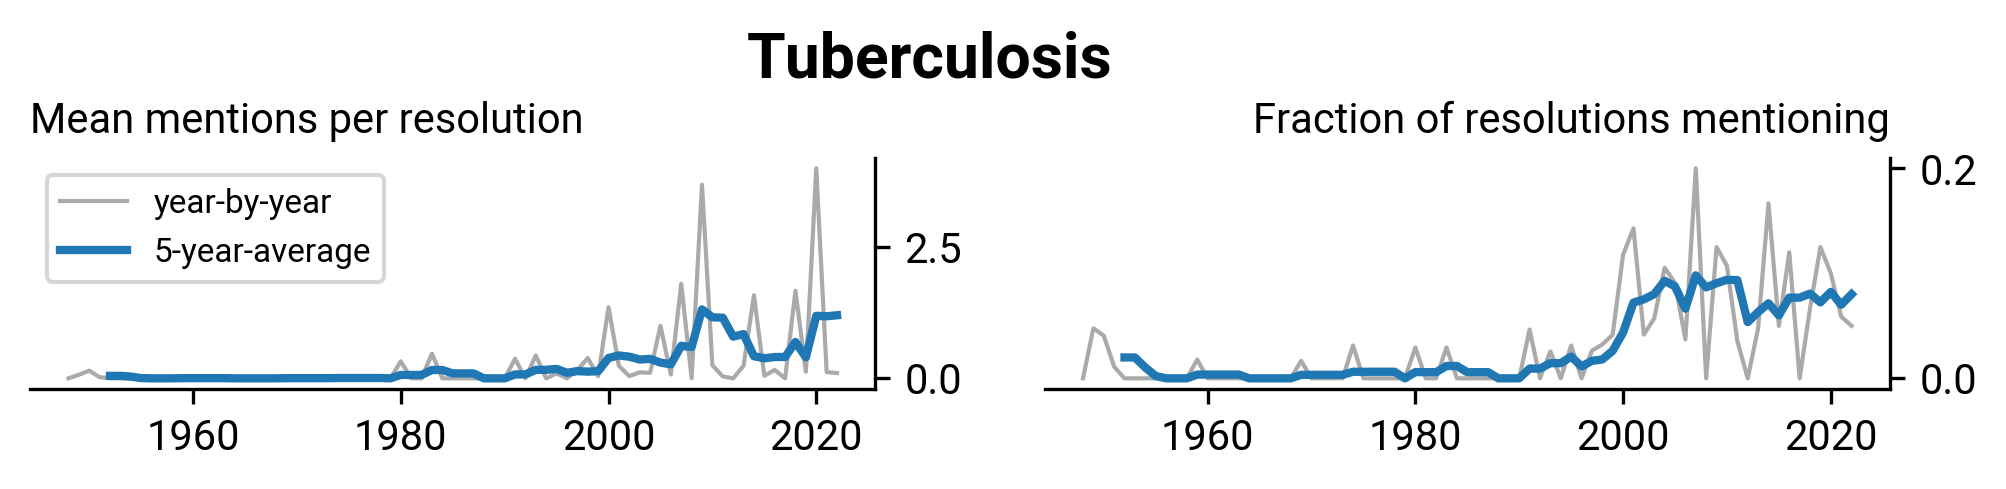

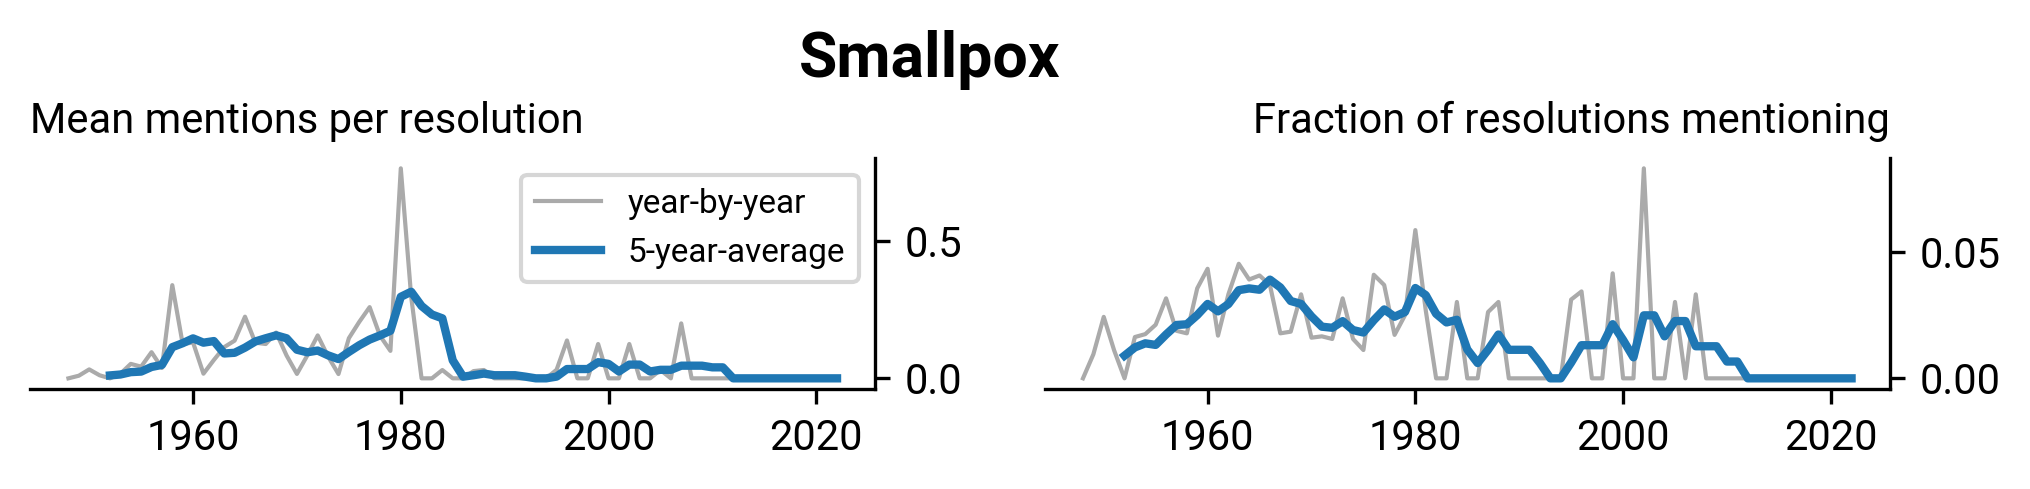

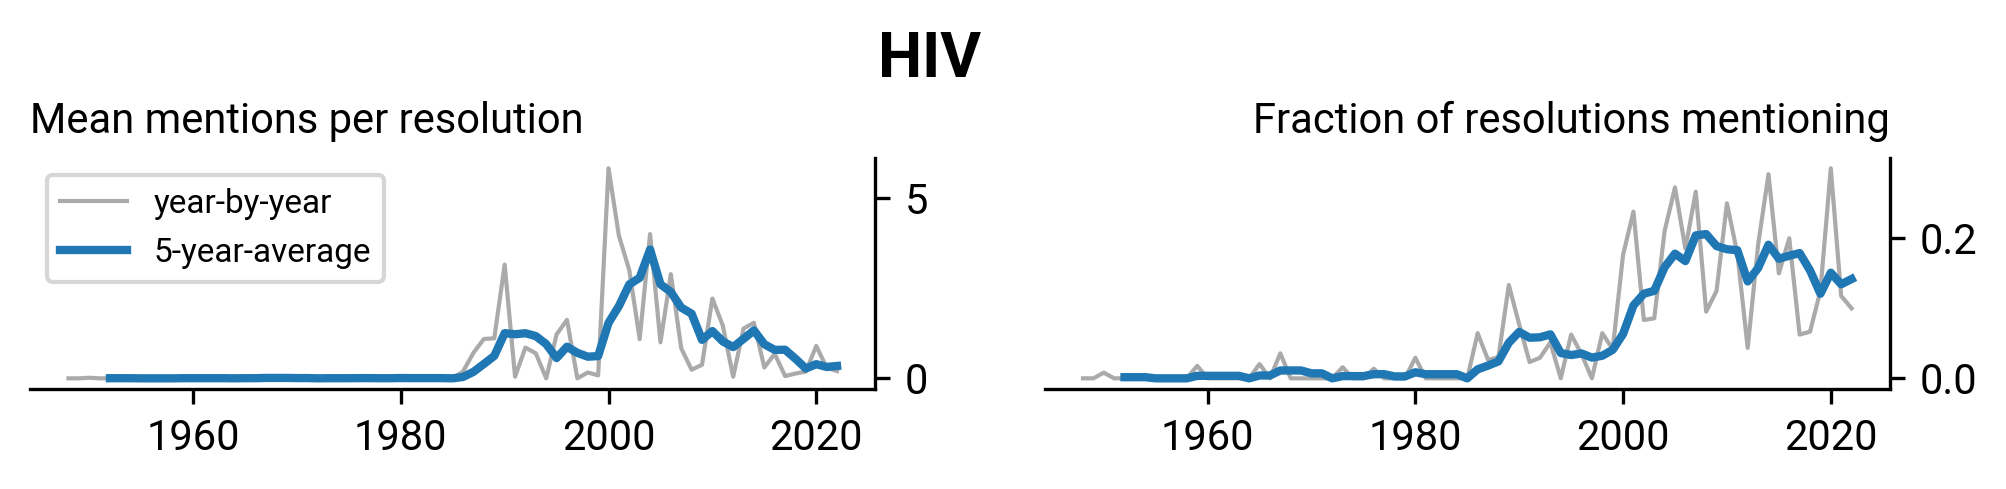

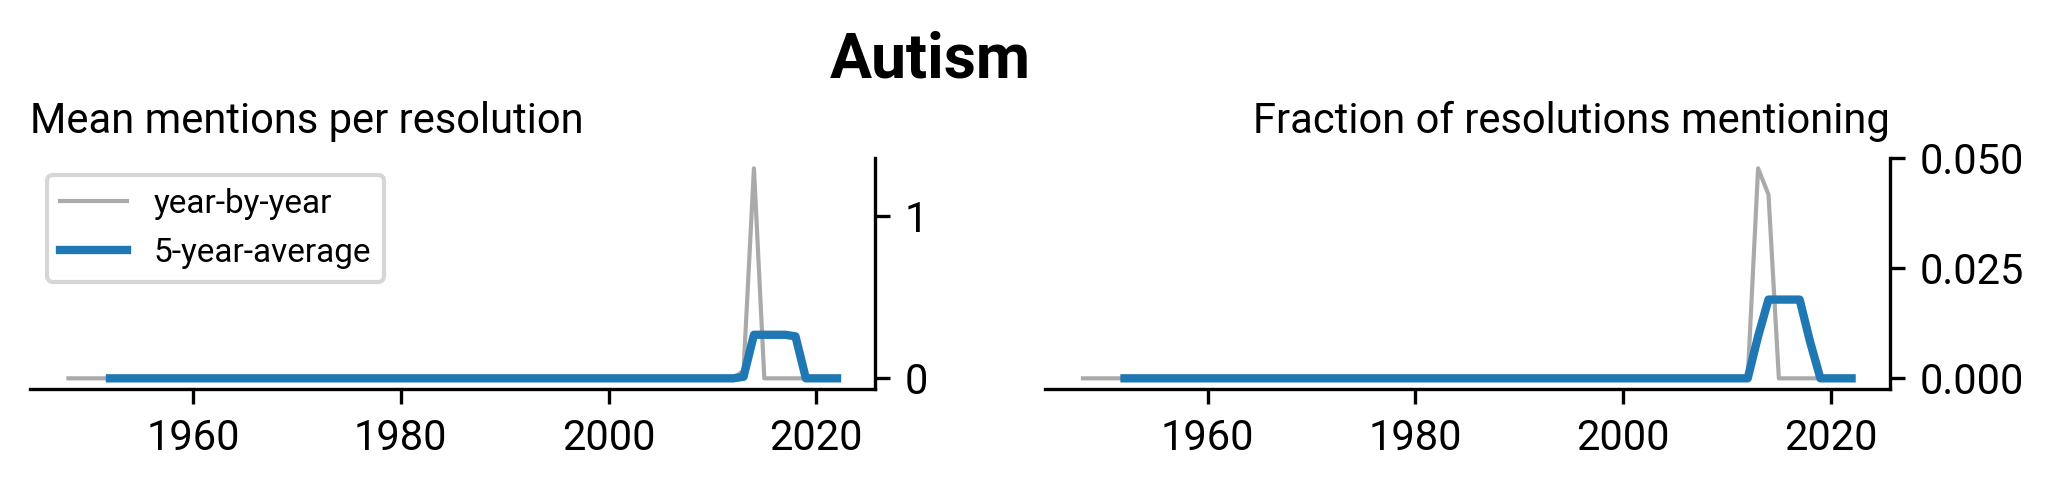

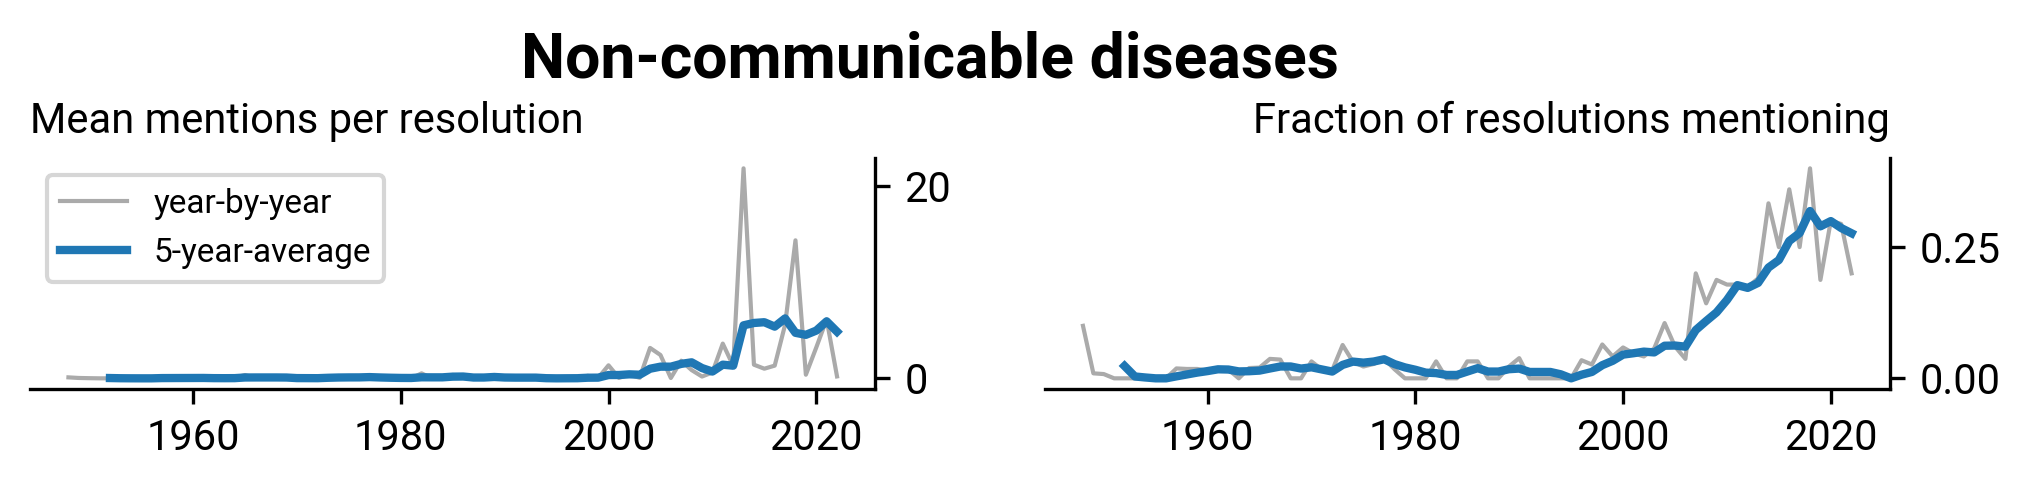

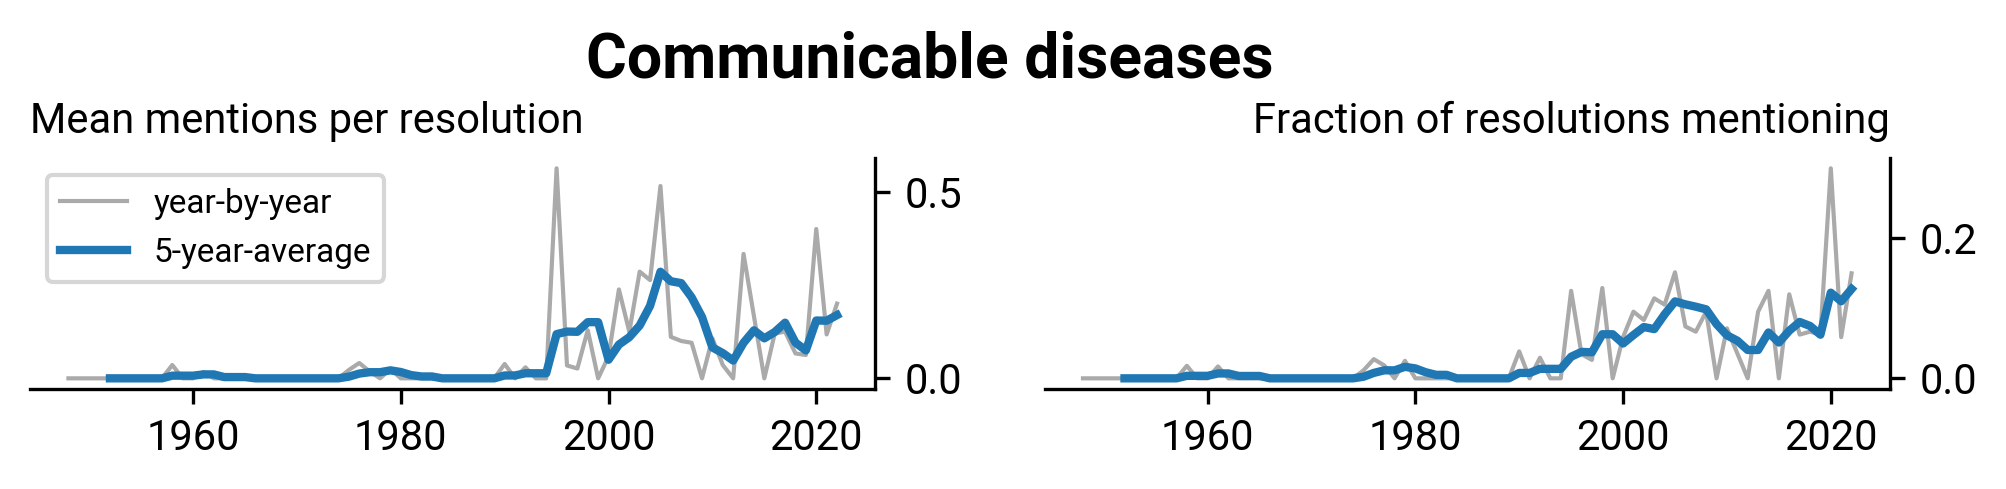

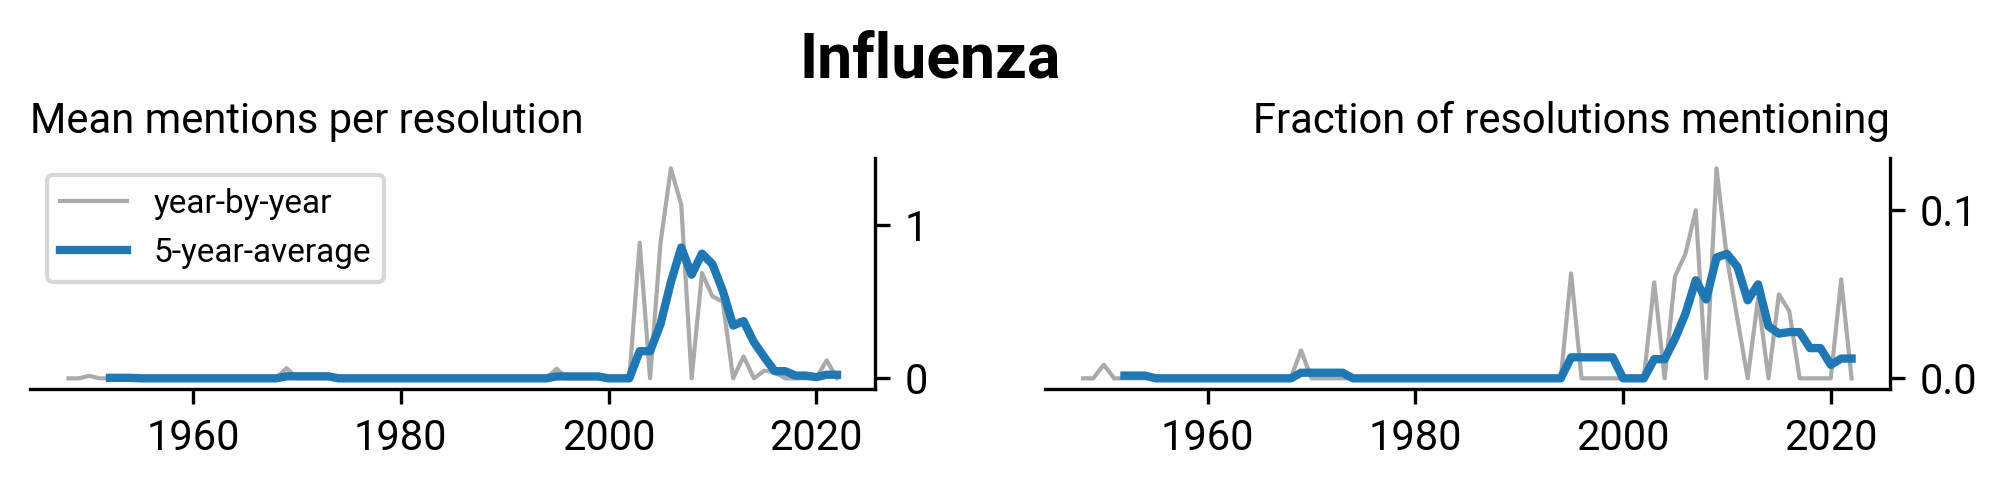

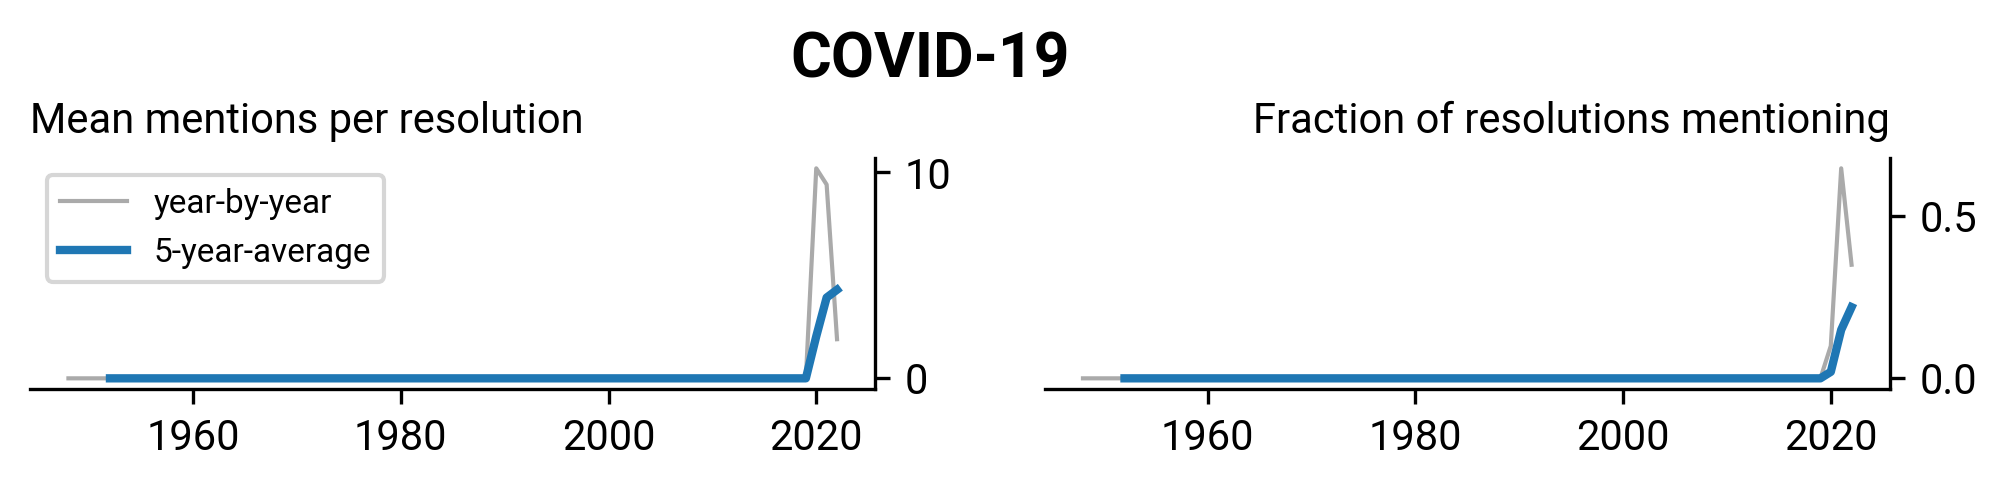

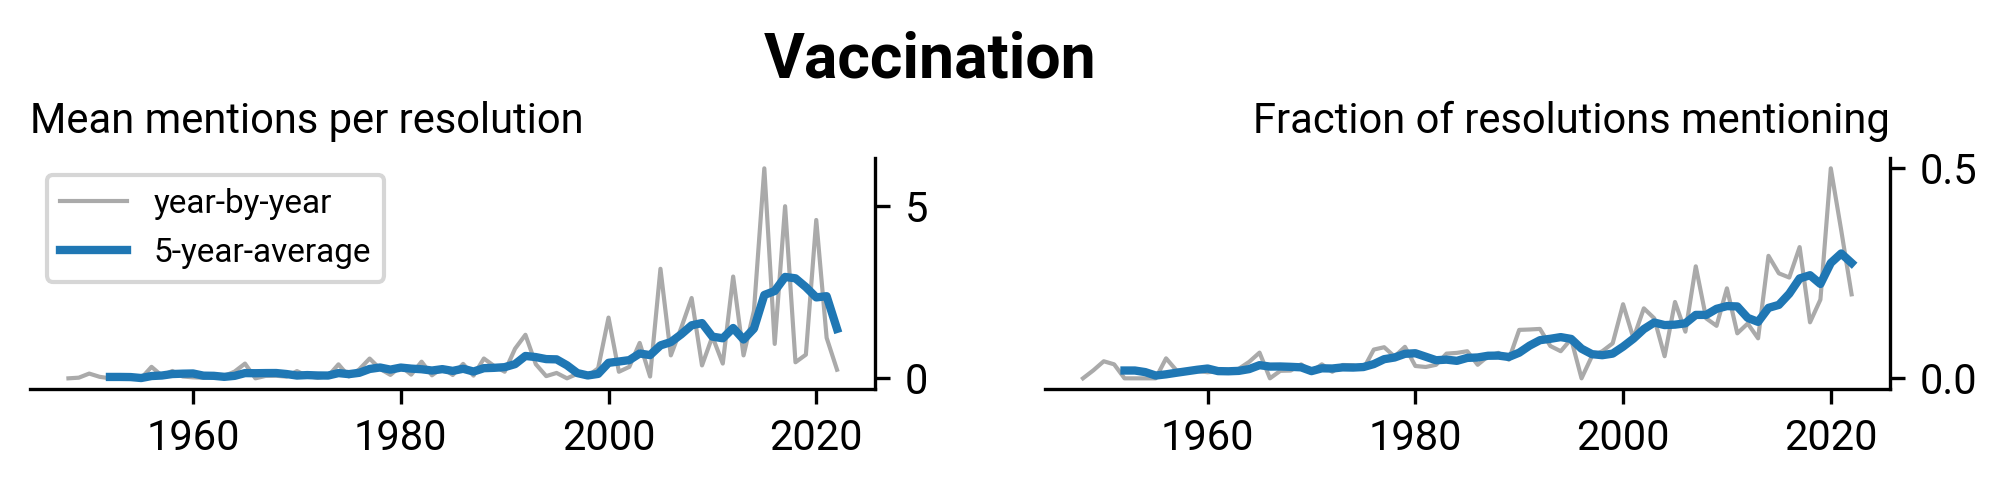

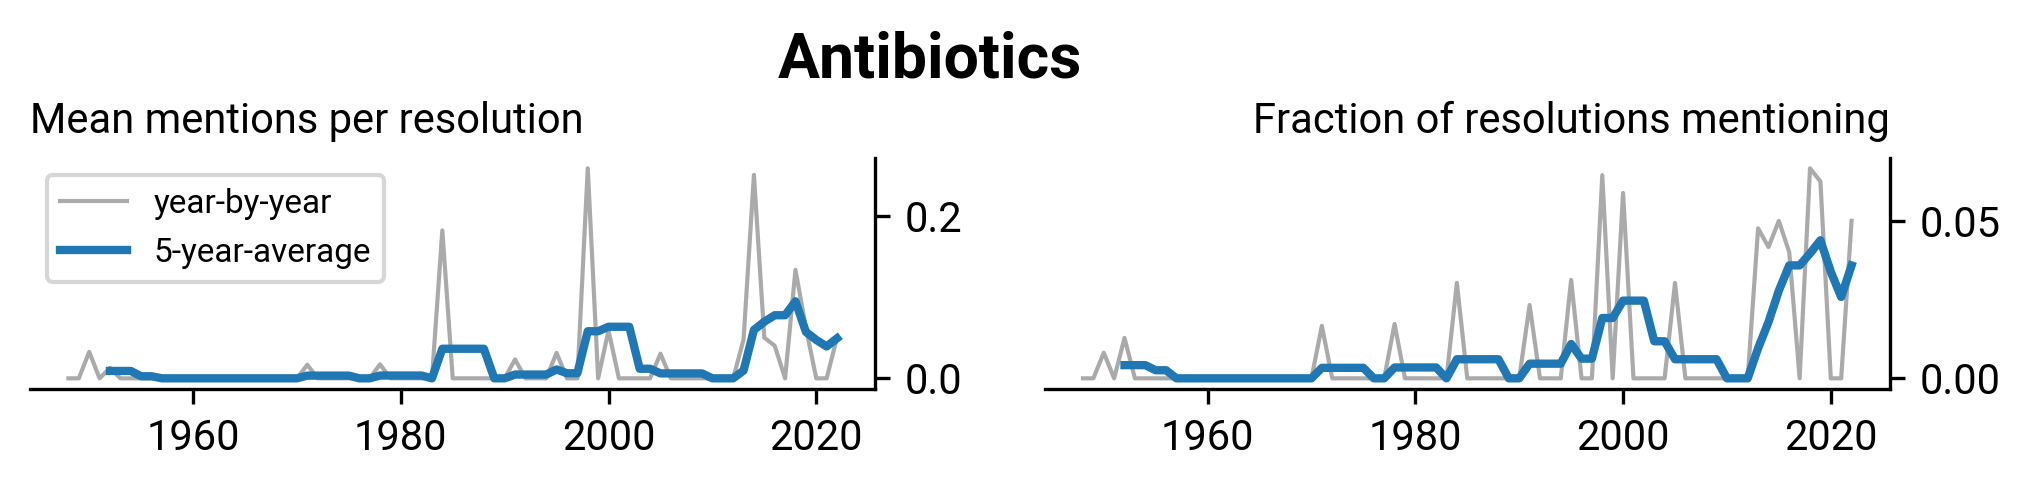

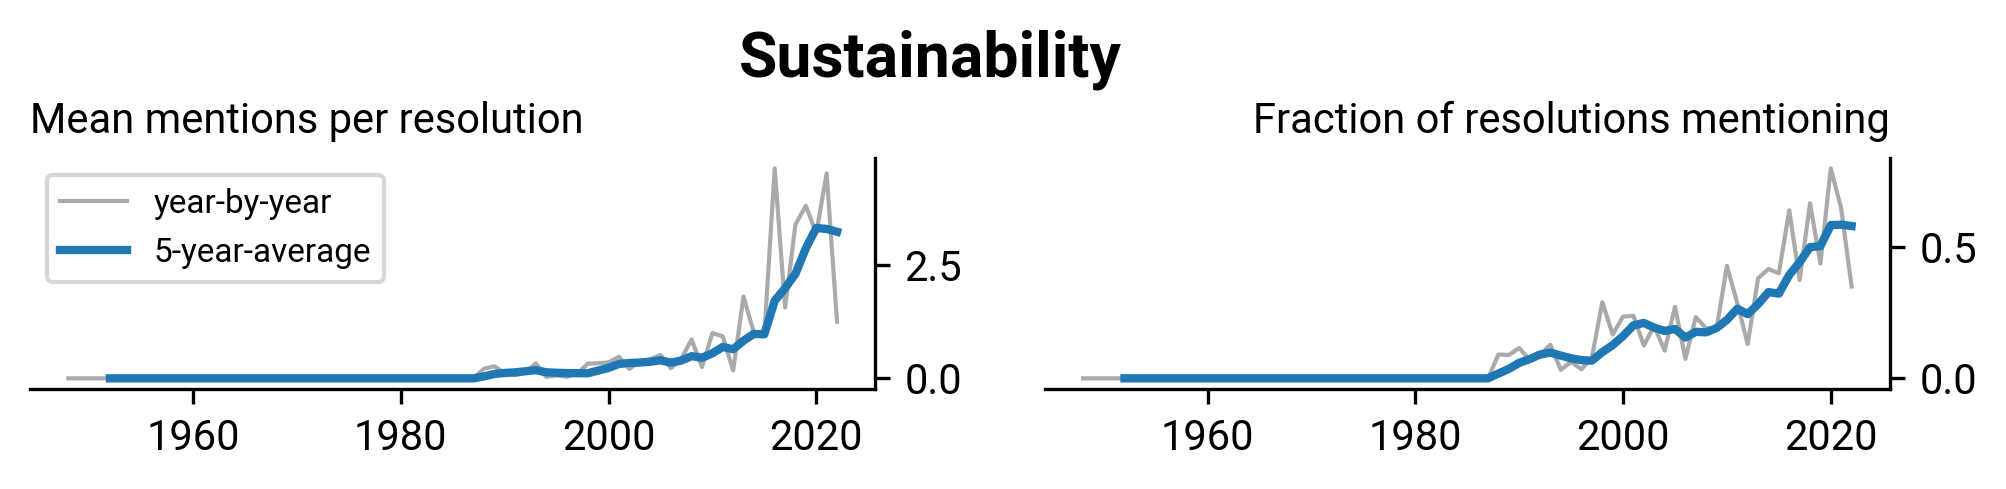

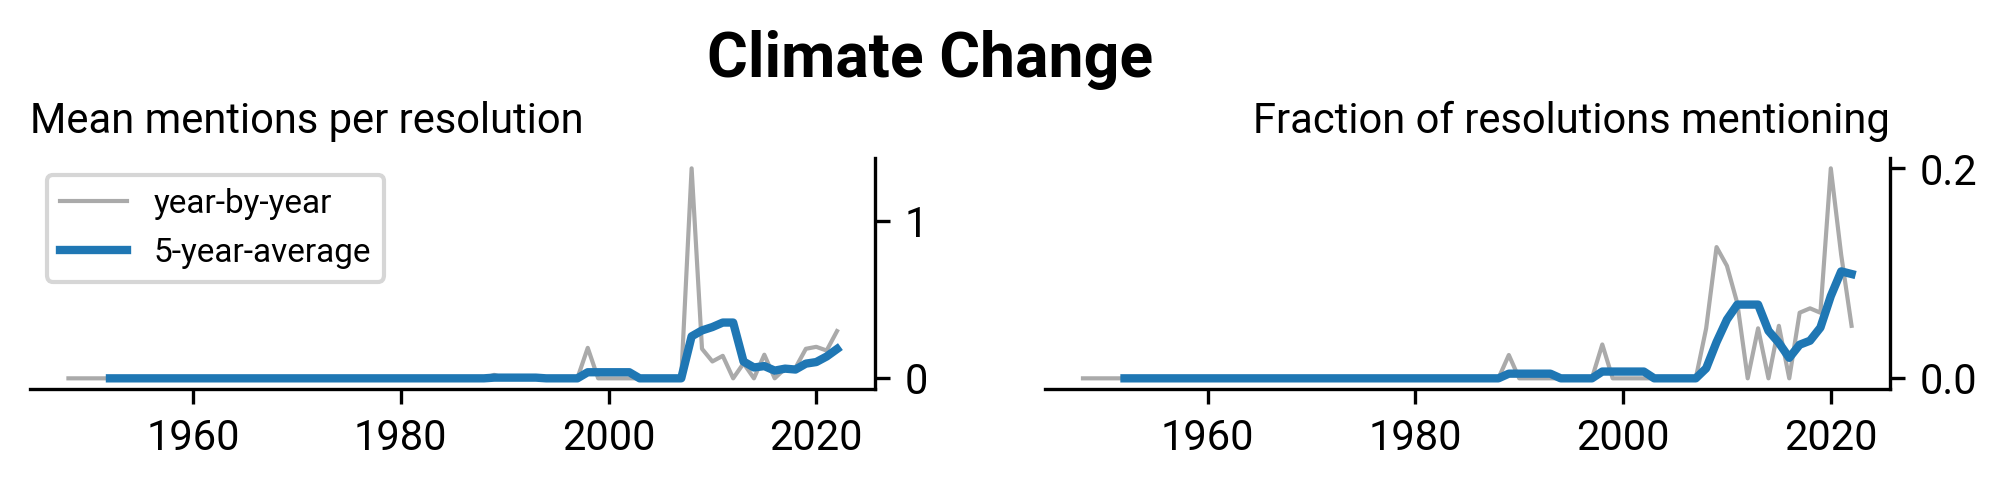

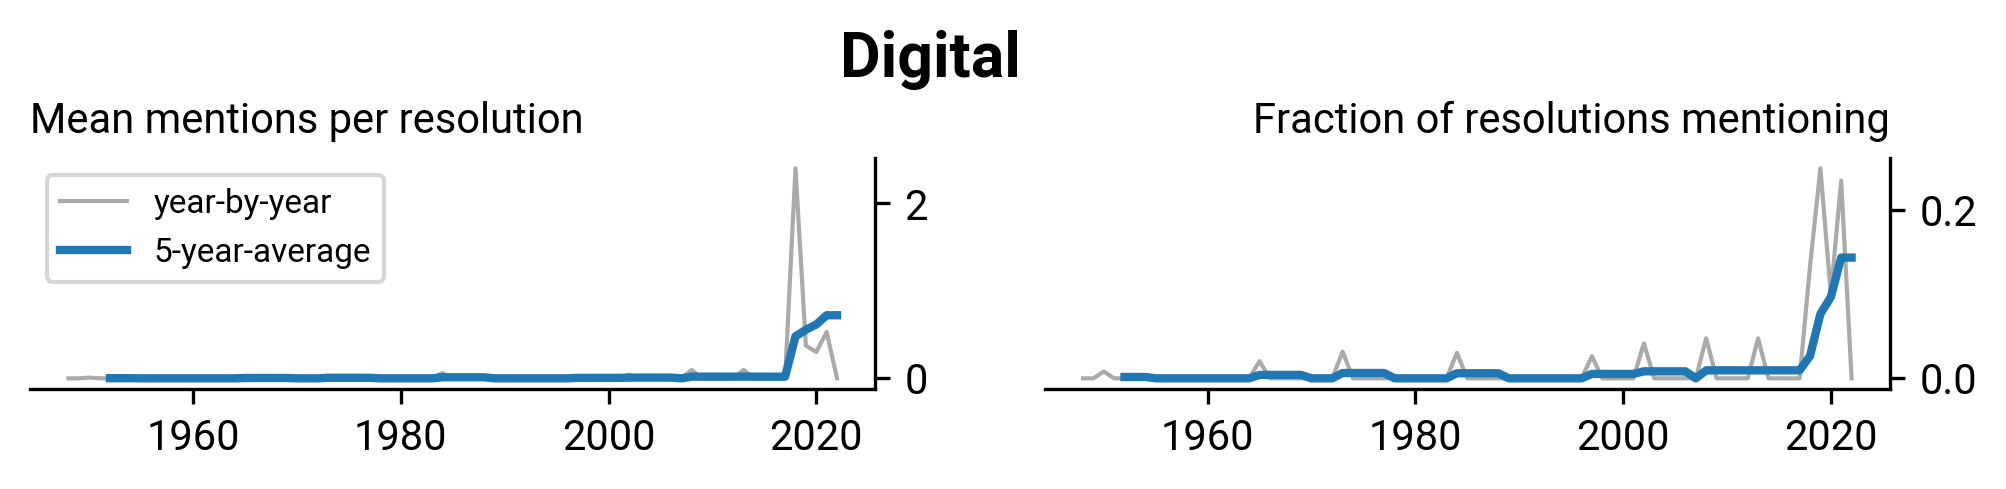

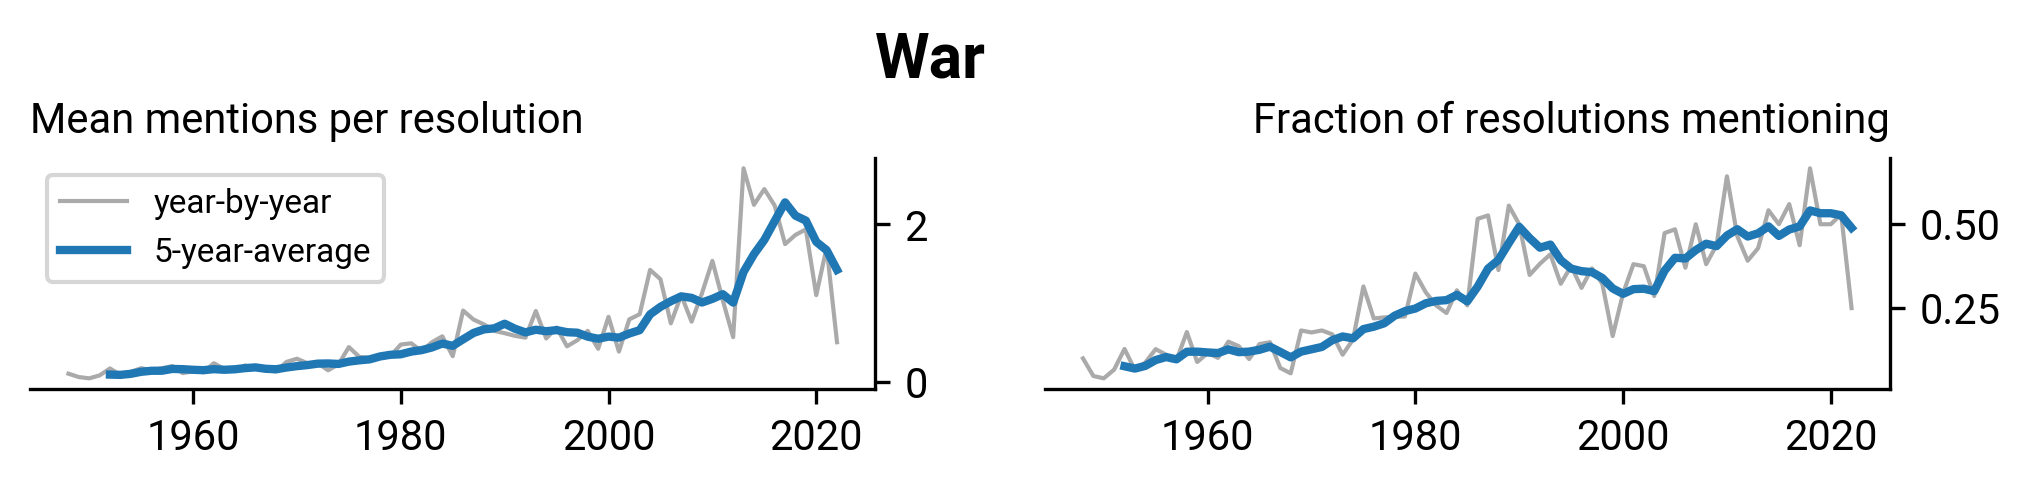

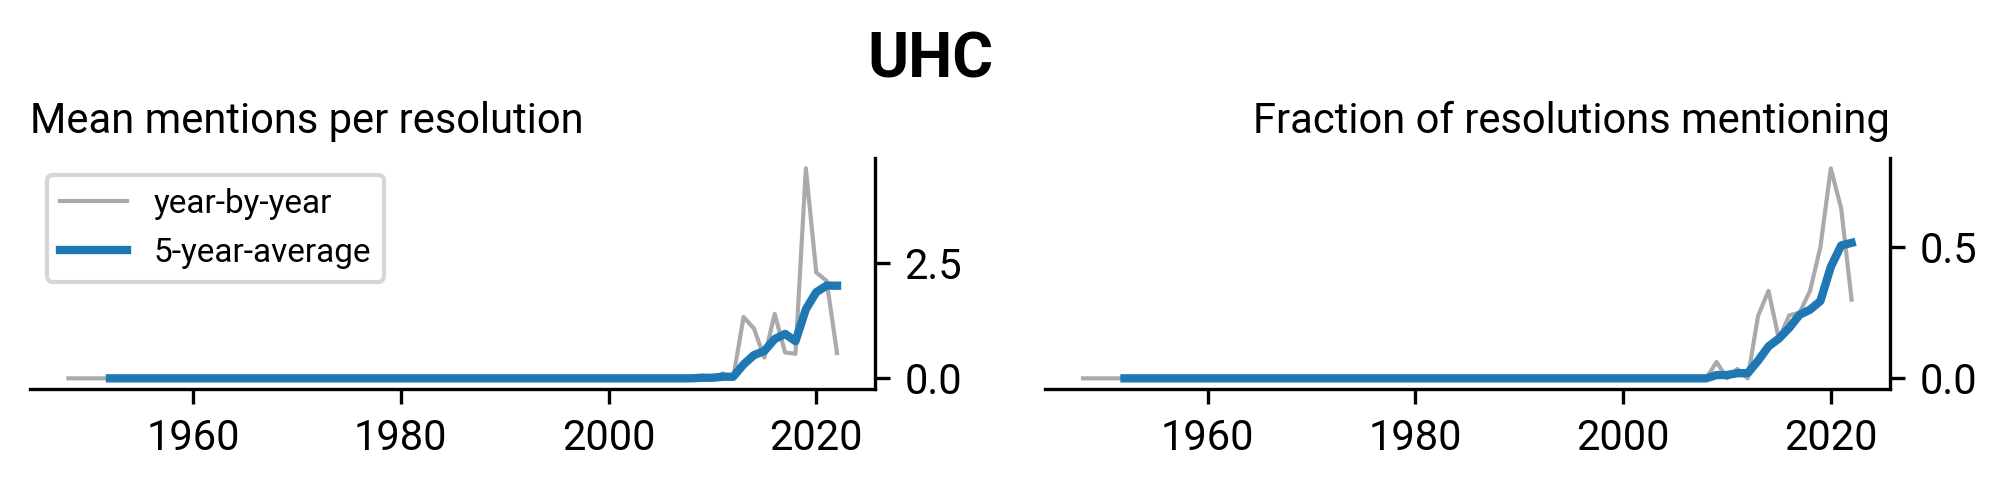

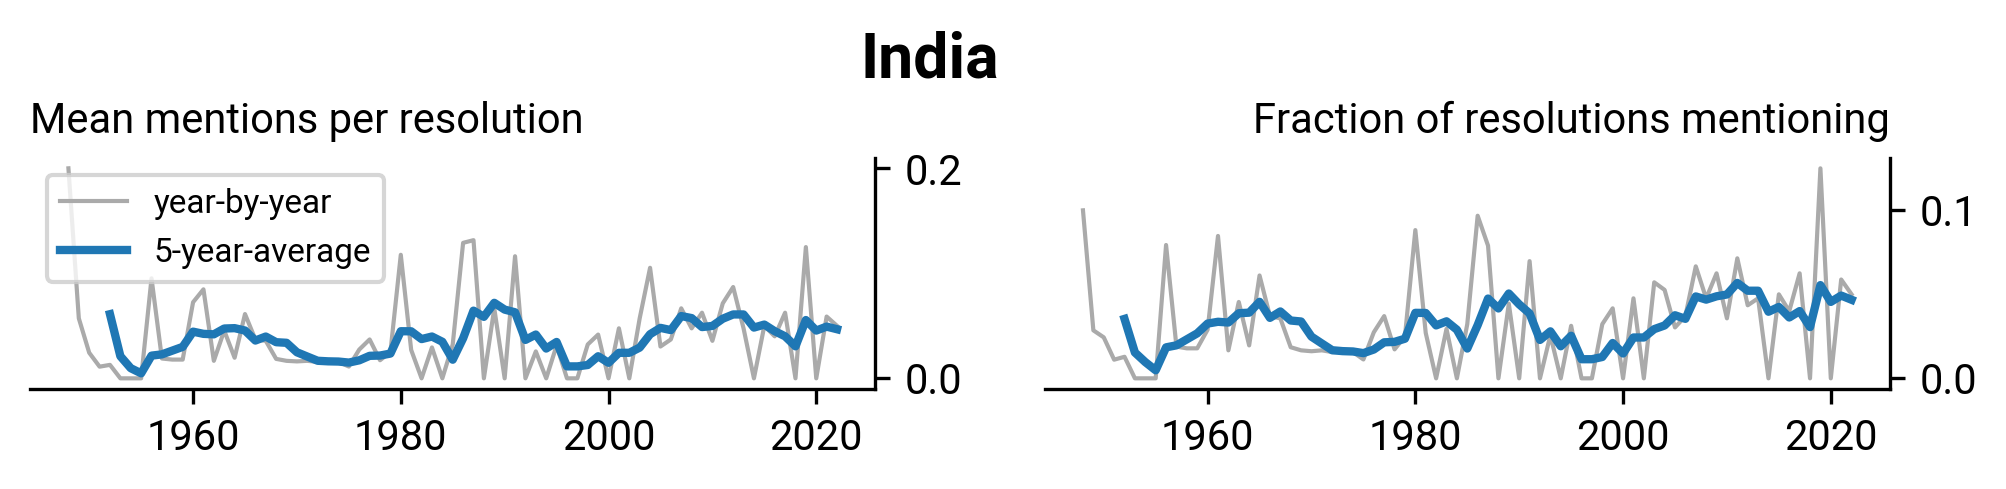

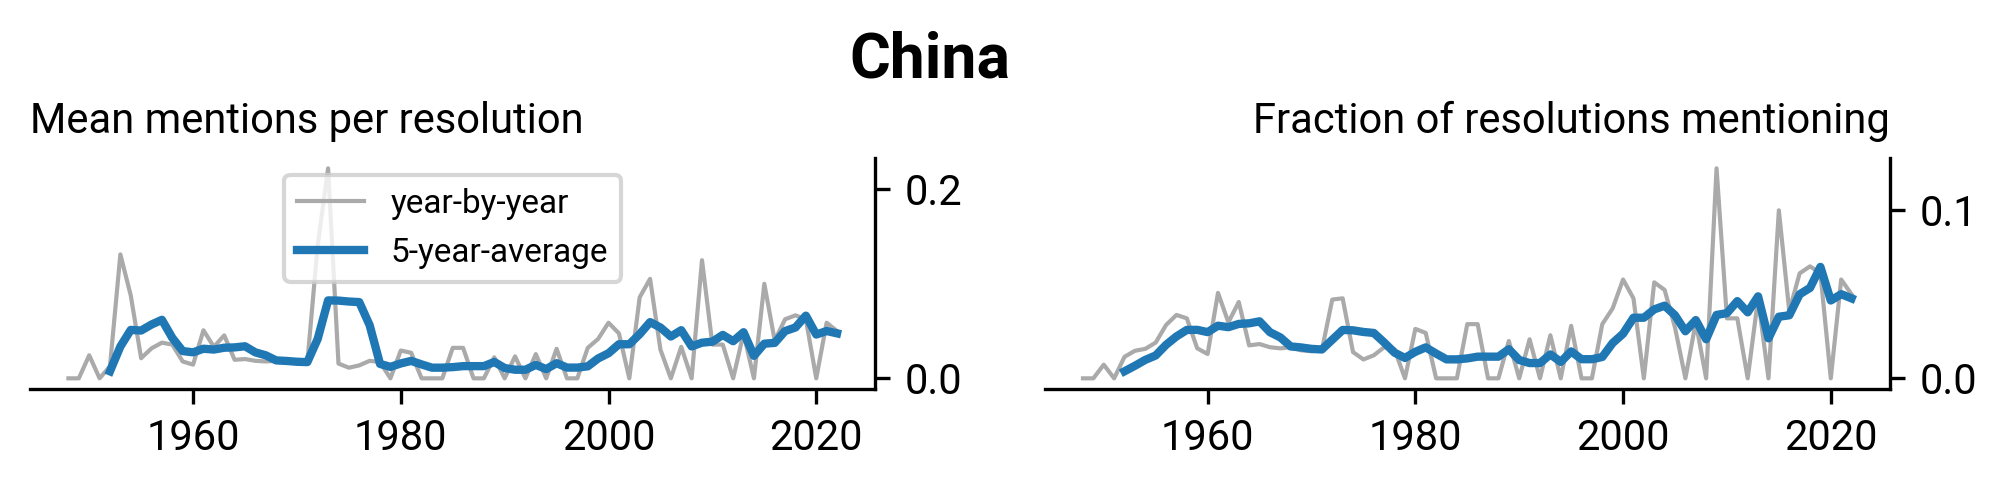

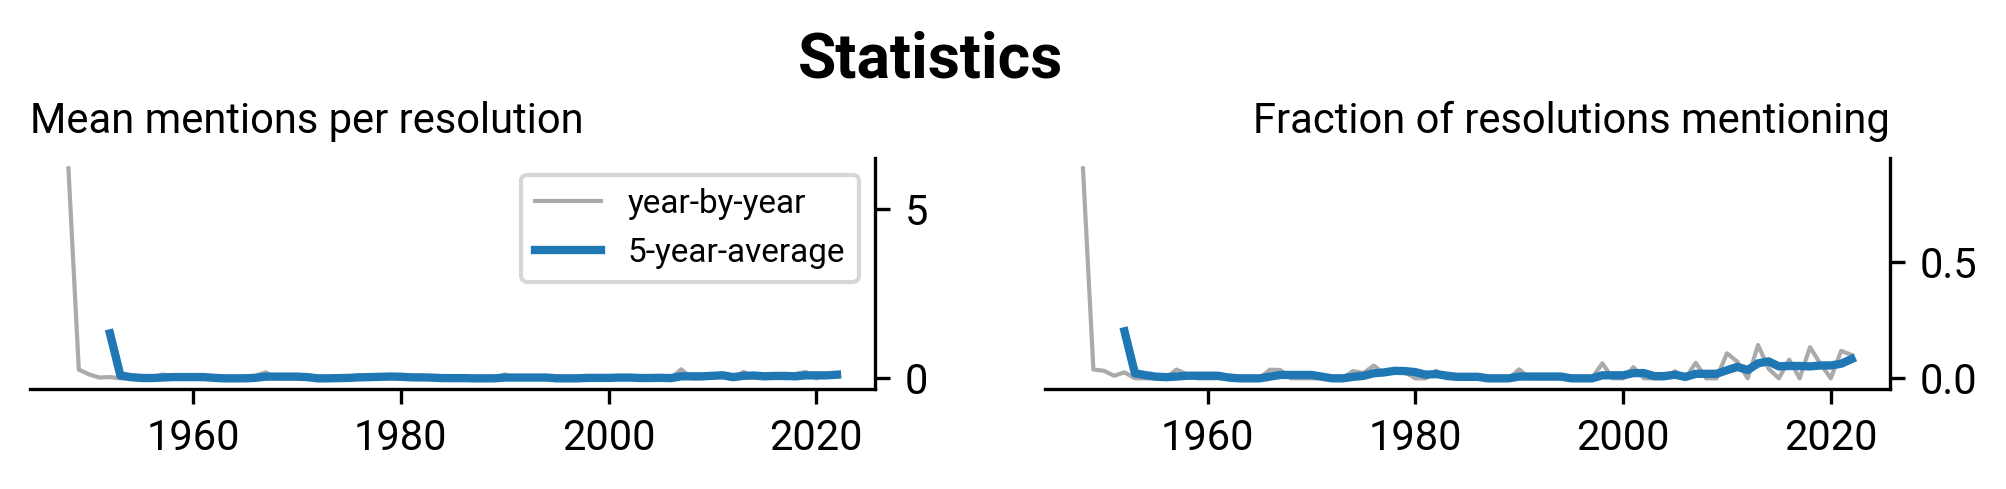

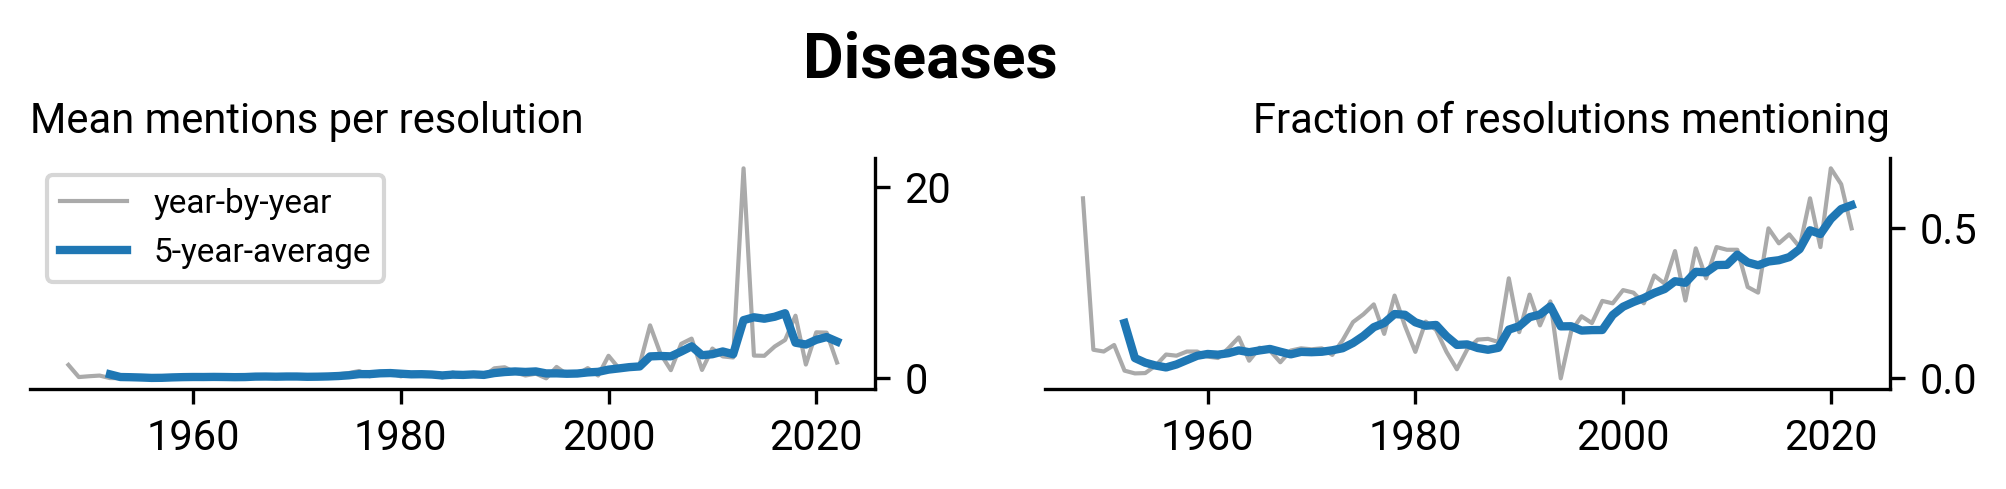

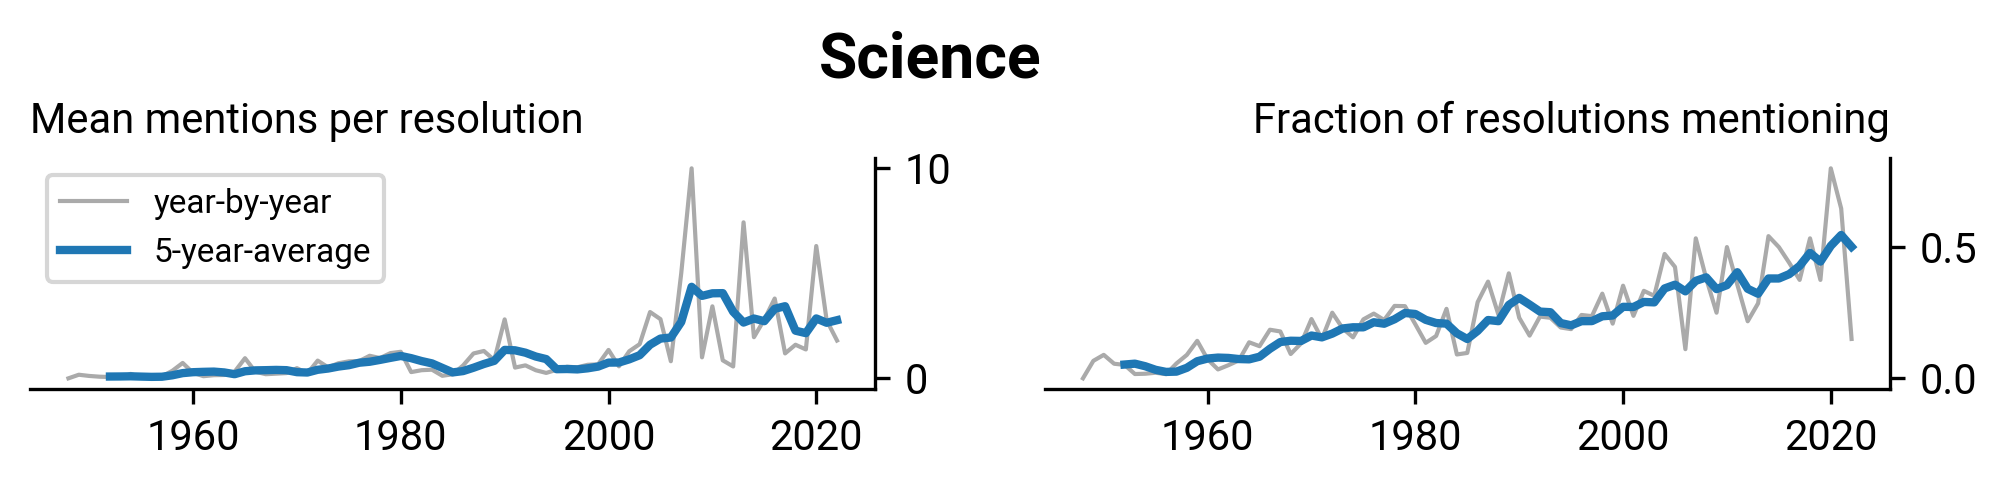

In [5]:
# Plotting a few topics vs time
window_size = 5
for topic in topics:
    fig, ax = plt.subplots(1, 2, figsize=(8, 1))
    df_group = df.groupby("year")[topic].mean().reset_index()
    ax[0].plot(df_group["year"], df_group[topic], linewidth=1, color="#aaaaaa", label="year-by-year")
    ax[0].plot(df_group["year"], df_group[topic].rolling(window_size, center=False).mean(), linewidth=2, label=f"{window_size}-year-average")
    ax[0].set_title("Mean mentions per resolution", fontsize=10, loc='left')
    # ax[0].grid()
    ax[0].legend(fontsize=8)
    ax[0].spines['top'].set_visible(False)
    # ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    # ax[0].spines['bottom'].set_visible(False)
    ax[0].yaxis.tick_right()
    ax[0].text(0.5, 1.15, topic, transform=fig.transFigure, fontsize=15, fontweight="bold", ha="center")

    df["present"] = df[topic]>0
    df_group = df.groupby("year")["present"].mean().reset_index()
    ax[1].plot(df_group["year"], df_group["present"], linewidth=1, color="#aaaaaa", label="year-by-year")
    ax[1].plot(df_group["year"], df_group["present"].rolling(window_size, center=False).mean(), linewidth=2, label=f"{window_size}-year-average")
    ax[1].set_title("Fraction of resolutions mentioning", fontsize=10, loc='right')
    # ax[1].grid()
    # ax[1].legend(fontsize=8)
    ax[1].spines['top'].set_visible(False)
    # ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    # ax[1].spines['bottom'].set_visible(False)
    ax[1].yaxis.tick_right()


In [6]:
# Create corpus and stemmized corpus
def remove_special_characters(string):
    pattern = r'[^a-zA-Z0-9-]'

    cleaned_string = re.sub(pattern, '', string)
    
    return cleaned_string

def remove_stop_words(tokenized_text, stop_words):
    filtered_text = []
    for t in tokenized_text:
        if t in stop_words:
            continue
        else:
            filtered_text.append(t)
    return filtered_text

def clean_text(tokenized_text):
    filtered_text = [w for w in tokenized_text if len(w)>1]
    filtered_text = [remove_special_characters(tt).strip() for tt in filtered_text]
    filtered_text = [re.sub(r'\d+', '', tt) for tt in filtered_text]
    filtered_text = [tt.strip() for tt in filtered_text if tt!=""]
    return filtered_text

# Stop words expanded list: use when internet is working well again
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = stopwords_list.decode().splitlines()
stop_words.extend(stopwords.words('english'))
stop_words.extend(['resolution', 're', 'wha', 'eb', 'resolution', 'decision', 'hbk'])
counter_strings = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth', 'eleventh', 'twelfth', 'thirteenth', 'fourteenth', 'fifteenth', 'sixteenth', 'seventeenth', 'eighteenth', 'nineteenth', 'twentieth', 'twenty', 'thirtieth', 'thirty', 'fortieth', 'forty', 'fiftieth', 'fifty', 'sixtieth', 'sixty', 'seventieth', 'seventy']
stop_words.extend(counter_strings)
stop_words.extend(['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december'])
# stop_words = set(stop_words)

ps = PorterStemmer()
corpus, stemmized_corpus = [], []
corpus_titles, stemmized_corpus_titles = [], []
for i in range(len(df)):
    tokenized_text = df.loc[i, "text"].lower().replace('-', ' ').split()
    tokenized_text = clean_text(tokenized_text)
    tokenized_text = remove_stop_words(tokenized_text, stop_words)
    tokenized_text = clean_text(tokenized_text)
    corpus.append(" ".join(tokenized_text))
    stemmized_text = [ps.stem(w) for w in tokenized_text]
    stemmized_corpus.append(" ".join(stemmized_text))
    
    xx = clean_text(df.loc[i, "title"].lower().split())
    xx = remove_stop_words(xx, stop_words)
    xx = clean_text(xx)
    # xx = [x.encode("ascii", "ignore").decode() for x in xx]
    # xx = [x.replace("\u200E", "") for x in xx]
    corpus_titles.append(" ".join(xx))
    # print(xx)
    xx = [ps.stem(w) for w in xx]
    stemmized_corpus_titles.append(" ".join(xx))


## Identification of topics and grouping by their time evolution

To uncover more topics covered by WHA resolutions, and use them to find relationships between WHA resolutions, I looked towards natural language processing and network analysis. I used TF-IDF vectorization to find keywords/topics for each resolution and built a network of WHA resolutions by comparing these identified keyword lists.

I won't go into many details behind the natural language processing pipeline and will only briefly summarize it. Each resolution is associated with two strings - `title` and `text`. For both of these strings, I performed the usual NLP pre-processing steps like tokenization, removal of stop words, and additional text cleaning like removing special characters and numbers. Then, I also stemmized all the tokens (words) in these strings so that different words like "sustainability", "sustainable", "sustain", "sustains", "sustaining", "sustained" were all reduced to a common form "sustain". This collection of cleaned and stemmized documents (each resolution is a document) is called a corpus. We have two stemmized corpuses - `corpus_title` and `corpus_text`. For the following explanation, I'll refer to `corpus_text` as the corpus, and I used only the `corpus_text` in this study. 

So, the corpus is a collection of documents (resolutions), and each document is a collection of words (after having removed special characters, numbers and stop words which are commonly occuring English words like "the", "a" etc.). For each word in the corpus, I calculated its `document frequency`, which is the fraction of documents containing the word. For each pair of word and document, I also calculated the `TF-IDF score`, a score that is a combination of term frequency and inverse document frequency. What is important to note is that TF-IDF score is intended to reflect how important a word is to a document. 

First, we'll check these two values for all the words in the corpus, and also check how the vocabulary size (no. of words) changes as we modify the minimum document frequency and maximum document frequency allowed.

/Users/rprizak/miniconda-m1/envs/theindiaproject/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


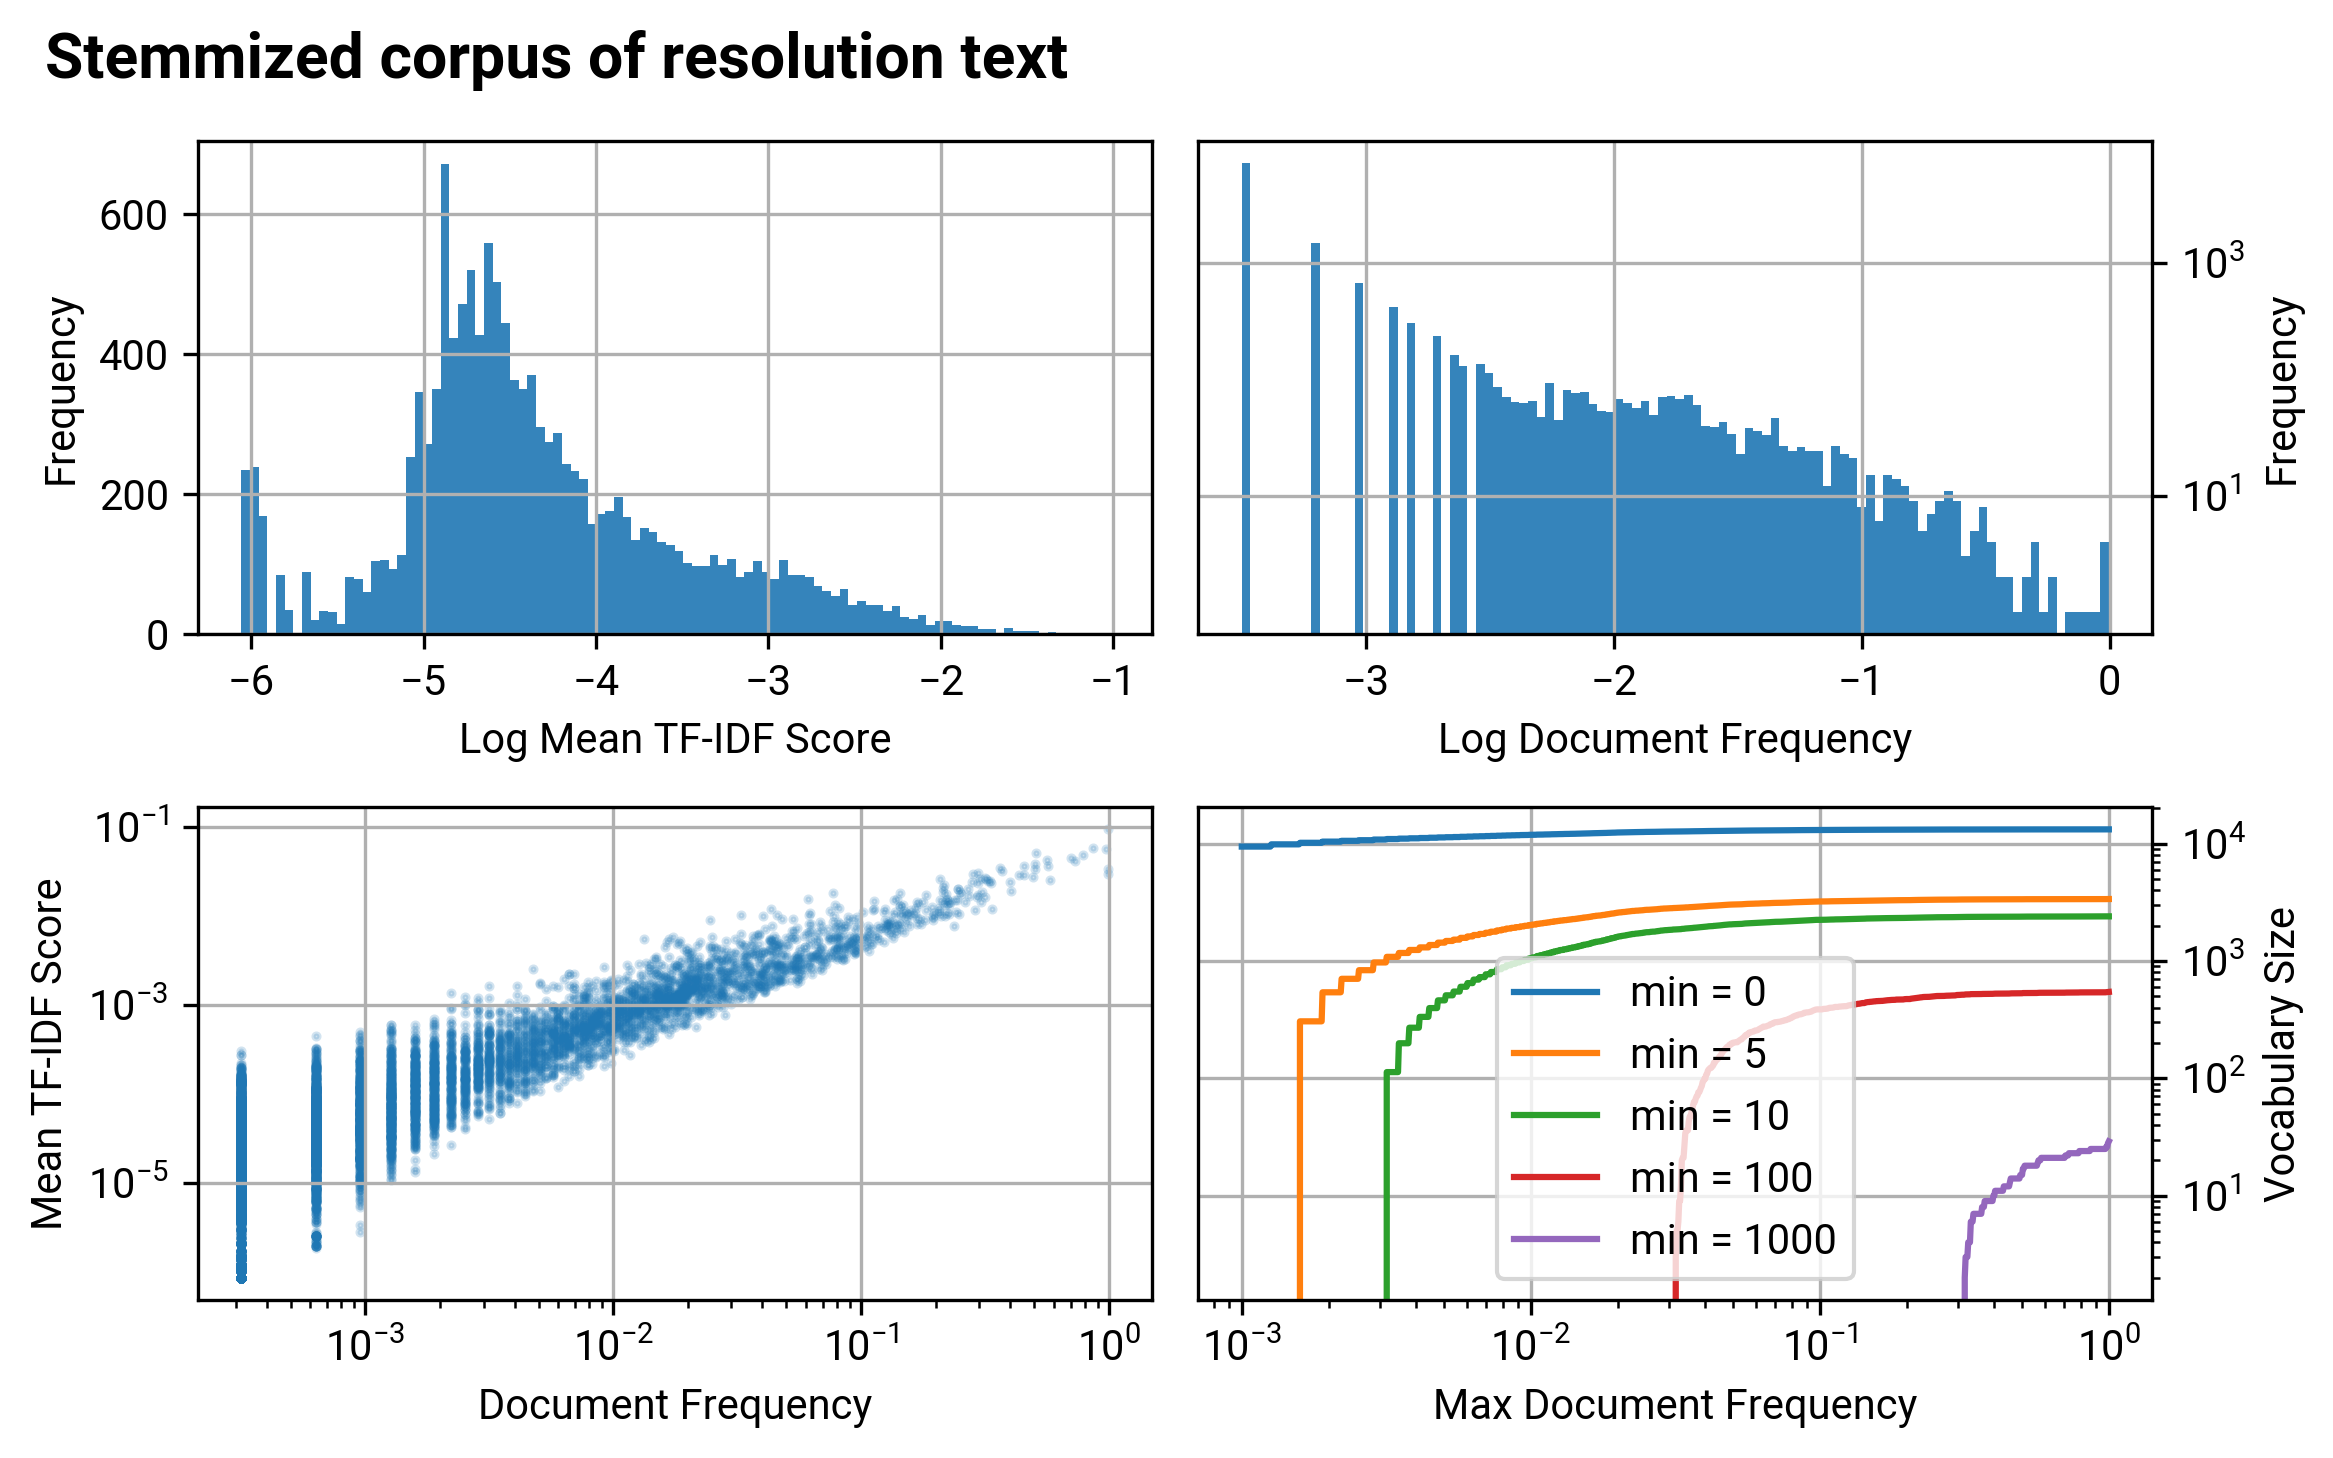

In [7]:
#| warning: False

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(stemmized_corpus)
feature_names = vectorizer.get_feature_names()
average_tfidf_scores = tfidf_matrix.mean(axis=0).A1
document_frequency = (tfidf_matrix > 0).sum(axis=0).A1 / tfidf_matrix.shape[0]
df_words = pd.DataFrame({'word': feature_names,
                         'tf_idf': average_tfidf_scores,
                         'doc_f': document_frequency})

df_words = df_words.sort_values('tf_idf', ascending=False)
    
min_df_values = [0, 0.001, 0.01, 0.1]
labels = ['min_df = 0%', 'min_df = 0.1%', 'min_df = 1%', 'min_df = 10%']
min_df_values = [1, 5, 10, 100, 1000]
labels = ['min = 0', 'min = 5', 'min = 10', 'min = 100', 'min = 1000']
x_df_values = np.logspace(-3, 0, 1000)

x_values = []
y_values = []

for min_df in min_df_values:
    word_counts = []

    for x_df in x_df_values:
        num_words = ((df_words['doc_f'] >= min_df/len(stemmized_corpus)) & (df_words['doc_f'] <= x_df)).sum()
        word_counts.append(num_words)
        
    x_values.append(x_df_values)
    y_values.append(word_counts)
    
log_average_tfidf_scores = np.log10(average_tfidf_scores)
log_document_frequency = np.log10(document_frequency)


fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0,0].hist(log_average_tfidf_scores, bins=100, alpha=0.9)
ax[0,0].set_xlabel('Log Mean TF-IDF Score')
ax[0,0].set_ylabel('Frequency')
ax[0,0].grid(True)

ax[0,1].hist(log_document_frequency, bins=100, alpha=0.9)
ax[0,1].set_xlabel('Log Document Frequency')
ax[0,1].set_ylabel('Frequency')
ax[0,1].grid(True)
ax[0,1].set_yscale('log')
ax[0,1].yaxis.tick_right()
ax[0,1].yaxis.set_label_position("right")

ax[1,0].scatter(df_words['doc_f'], df_words['tf_idf'], alpha=0.2, s=2)
ax[1,0].set_xlabel('Document Frequency')
ax[1,0].set_ylabel('Mean TF-IDF Score')
ax[1,0].grid(True)
ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

for i in range(len(min_df_values)):
    ax[1,1].plot(x_values[i], y_values[i], label=labels[i])
    
ax[1,1].set_xlabel('Max Document Frequency')
ax[1,1].set_ylabel('Vocabulary Size')
ax[1,1].legend()
ax[1,1].grid()
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].yaxis.tick_right()
ax[1,1].yaxis.set_label_position("right")

ax[0,0].text(0.04, 0.93, "Stemmized corpus of resolution text", transform=fig.transFigure, fontsize=15, fontweight="bold", ha="left")

fig.tight_layout()

Words with a very high document frequency are probably those that aren't very relevant to the specific topic of the resolution, and are just very often used in WHA resolutions. So, using a maximum allowed document frequency is a good way to exclude those words from further analysis. One can use a maximum document frequency of either 0.05 or 0.1. This means that one excludes words that are present in more than 5% (around 150 resolutions) or than 10% (around 300 resolutions) of documents. 

One can also put a minimum document frequency, which will require words to be present in at least a specific number of resolutions, for example 5, 10 or 50. This will get rid of super-specific words, typos and other such errors. Putting these restrictions on what words to consider, I then proceeded to calculate the TF-IDF score for each document-word pair. Remember, the TF-IDF score is intended to quantify a word's importance in a document. Then, for each document, I selected the top `n_w` words with the highest TF-IDF scores. 

I counted both single words (monograms) and two-word phrases (bigrams) - they will be called **topics** together. Using minimum document frequency as 50 resolutions, maximum document frequency as 5% (around 150 resolutions) and obtaining top `n_w = 10` topics from each document, I obtained a total of **1136 unique topics**.

Here are a few examples.

In [8]:
def extract_keywords(corpus, n_w, min_df, max_df, vocabulary=None, max_features=None, ngram_range=(1,1)):
    vectorizer = TfidfVectorizer(use_idf=True, norm='l2', min_df=min_df, max_df=max_df, ngram_range=ngram_range, vocabulary=vocabulary, max_features=max_features)
    X = vectorizer.fit_transform(corpus)

    keywords = []
    feature_names = vectorizer.get_feature_names_out()
    for i, document in enumerate(corpus):
        frequencies = X[i].toarray()[0]
        # print(sorted(frequencies, reverse=True))
        # document_keywords = [feature_names[j] for j, freq in enumerate(frequencies) if min_df <= freq <= max_df]
        document_keywords = [feature_names[j] for j, freq in enumerate(frequencies) if freq>0]
        document_frequencies = [freq for j, freq in enumerate(frequencies) if freq>0]
        sorted_indices = sorted(range(len(document_frequencies)), key=lambda i: document_frequencies[i], reverse=True)
        document_keywords = [document_keywords[j] for j in sorted_indices]
        keywords.append(document_keywords[:n_w])

    return keywords

In [9]:
n_w = 10
min_df = 50/len(stemmized_corpus)
max_df = 0.05

keywords_text = extract_keywords(stemmized_corpus, n_w, min_df, max_df, ngram_range=(1,2))

for i, document_keywords in enumerate(keywords_text):
    if random.random()<0.005:
        print(f"{df.loc[i, 'number']}: {df.loc[i, 'title']}")
        print(f"Topics: {', '.join(document_keywords)}\n")

WHA2.27: Insulin
Topics: gener studi, advis, explor, manufactur, possibl, programm adopt

WHA4.48: WHO seals
Topics: supplement, ona, assembl suspens, toit, inconform, suggest, organ request, gener submit, fund health, gener implement

WHA6.56: Special benefit for retiring Director-General
Topics: staff pension, pension, save, work capit, capit fund, capit, contract, occur, budget estim, sum

WHA15.34: Malaria eradication special account
Topics: malaria, erad, special account, erad programm, cash, voluntari contribut, transit, programm request, laid, regularli

WHA23.18: Headquarters accommodation: report on financing
Topics: headquart, real estat, estat, expens, real, sum, reflect, main, share, outcom

WHA29.37: Amendments to the rules of procedures of the World Health Assembly
Topics: point, presid, deleg, rule procedur, associ member, add, appeal, aris, follow, statement

WHA29.22: Report on the world health situation
Topics: health situat, publish, content, analysi, programm work, 

### Monograms + bigrams: topics and their time evolution

To visualize the found topics and their time evolution of occurance in WHA resolutions, I clustered the topics according to their time trajectory of counts and visualized it as a heatmap. Topics with similar trajectories are clustered together for easier visualization.

![1-gram + 2-gram clustered heatmap of topics](ngram12_cluster_heatmap.png)

In [ ]:
all_keywords_text = list(set([d for dd in keywords_text for d in dd]))
print(len(all_keywords_text))
df_keywords = pd.DataFrame(1, index=all_keywords_text, columns=all_years)
# df_keywords = pd.DataFrame(0, index=all_keywords_text, columns=all_years)

for i, document_keywords in enumerate(keywords_text):
    year = df.loc[i, 'year']
    for j, keyword in enumerate(document_keywords):
        df_keywords.loc[keyword, year]+=1
        # df_keywords.loc[keyword, year]=1
    
df_keywords['total'] = df_keywords.sum(axis=1)
# df_keywords = df_keywords.loc[df_keywords['total']>50,:]
df_keywords = np.log10(df_keywords)
df_keywords.sort_values('total', inplace=True)
df_keywords.drop('total', axis=1, inplace=True)
print(len(df_keywords))

In [ ]:
cg = sns.clustermap(df_keywords, figsize=(8,int(len(df_keywords)/10)), col_cluster=False, cbar_pos=None, yticklabels=1)
cg.ax_row_dendrogram.set_visible(False)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=6)  # ytick rotate

In [13]:
from sklearn.preprocessing import StandardScaler

df_keywords_normalized = pd.DataFrame(StandardScaler().fit_transform(df_keywords), index=df_keywords.index.to_list(), columns=all_years)

In [ ]:
# Run k-means for variable number of clusters and find elbow
from kneed import KneeLocator

sse = {}
for i in range(2,300):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_keywords_normalized)
    sse[i] = kmeans.inertia_

kn = KneeLocator(x=list(sse.keys()), 
                 y=list(sse.values()), 
                 curve='convex', 
                 direction='decreasing')

fig, ax = plt.subplots()
ax.plot(range(len(sse)), sse.values())

print(kn.knee)

In [ ]:
# Run k-means for optimal numer of clusters
n_clusters = 32
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(df_keywords_normalized)

### Topic trajectories grouped into clusters

The heatmap contains a lot of topics but we see that topics can be put into groups according to the similarity in their time evolution. I performed this grouping quantitatively by employing `k-means clustering`. Taking a matrix of presence/absence of topics in resolutions each year, I performed k-means clustering for a range of number of clusters to find the optimal number of clusters (elbow point). Then I performed k-means clustering for the optimal number of clusters (32), and visualized the time trajectories of each of these clusters; I also mention some of the topics in each cluster.

#### **Topics grouped according to similarity in time evolution**  
On the y-axis, I plotted a normalized value that reflects the relative occurance of topic words in resolutions by year. Each topic has a different normalization factor, so don't compare across topics; the plots only reflect relative change over years for each topic.

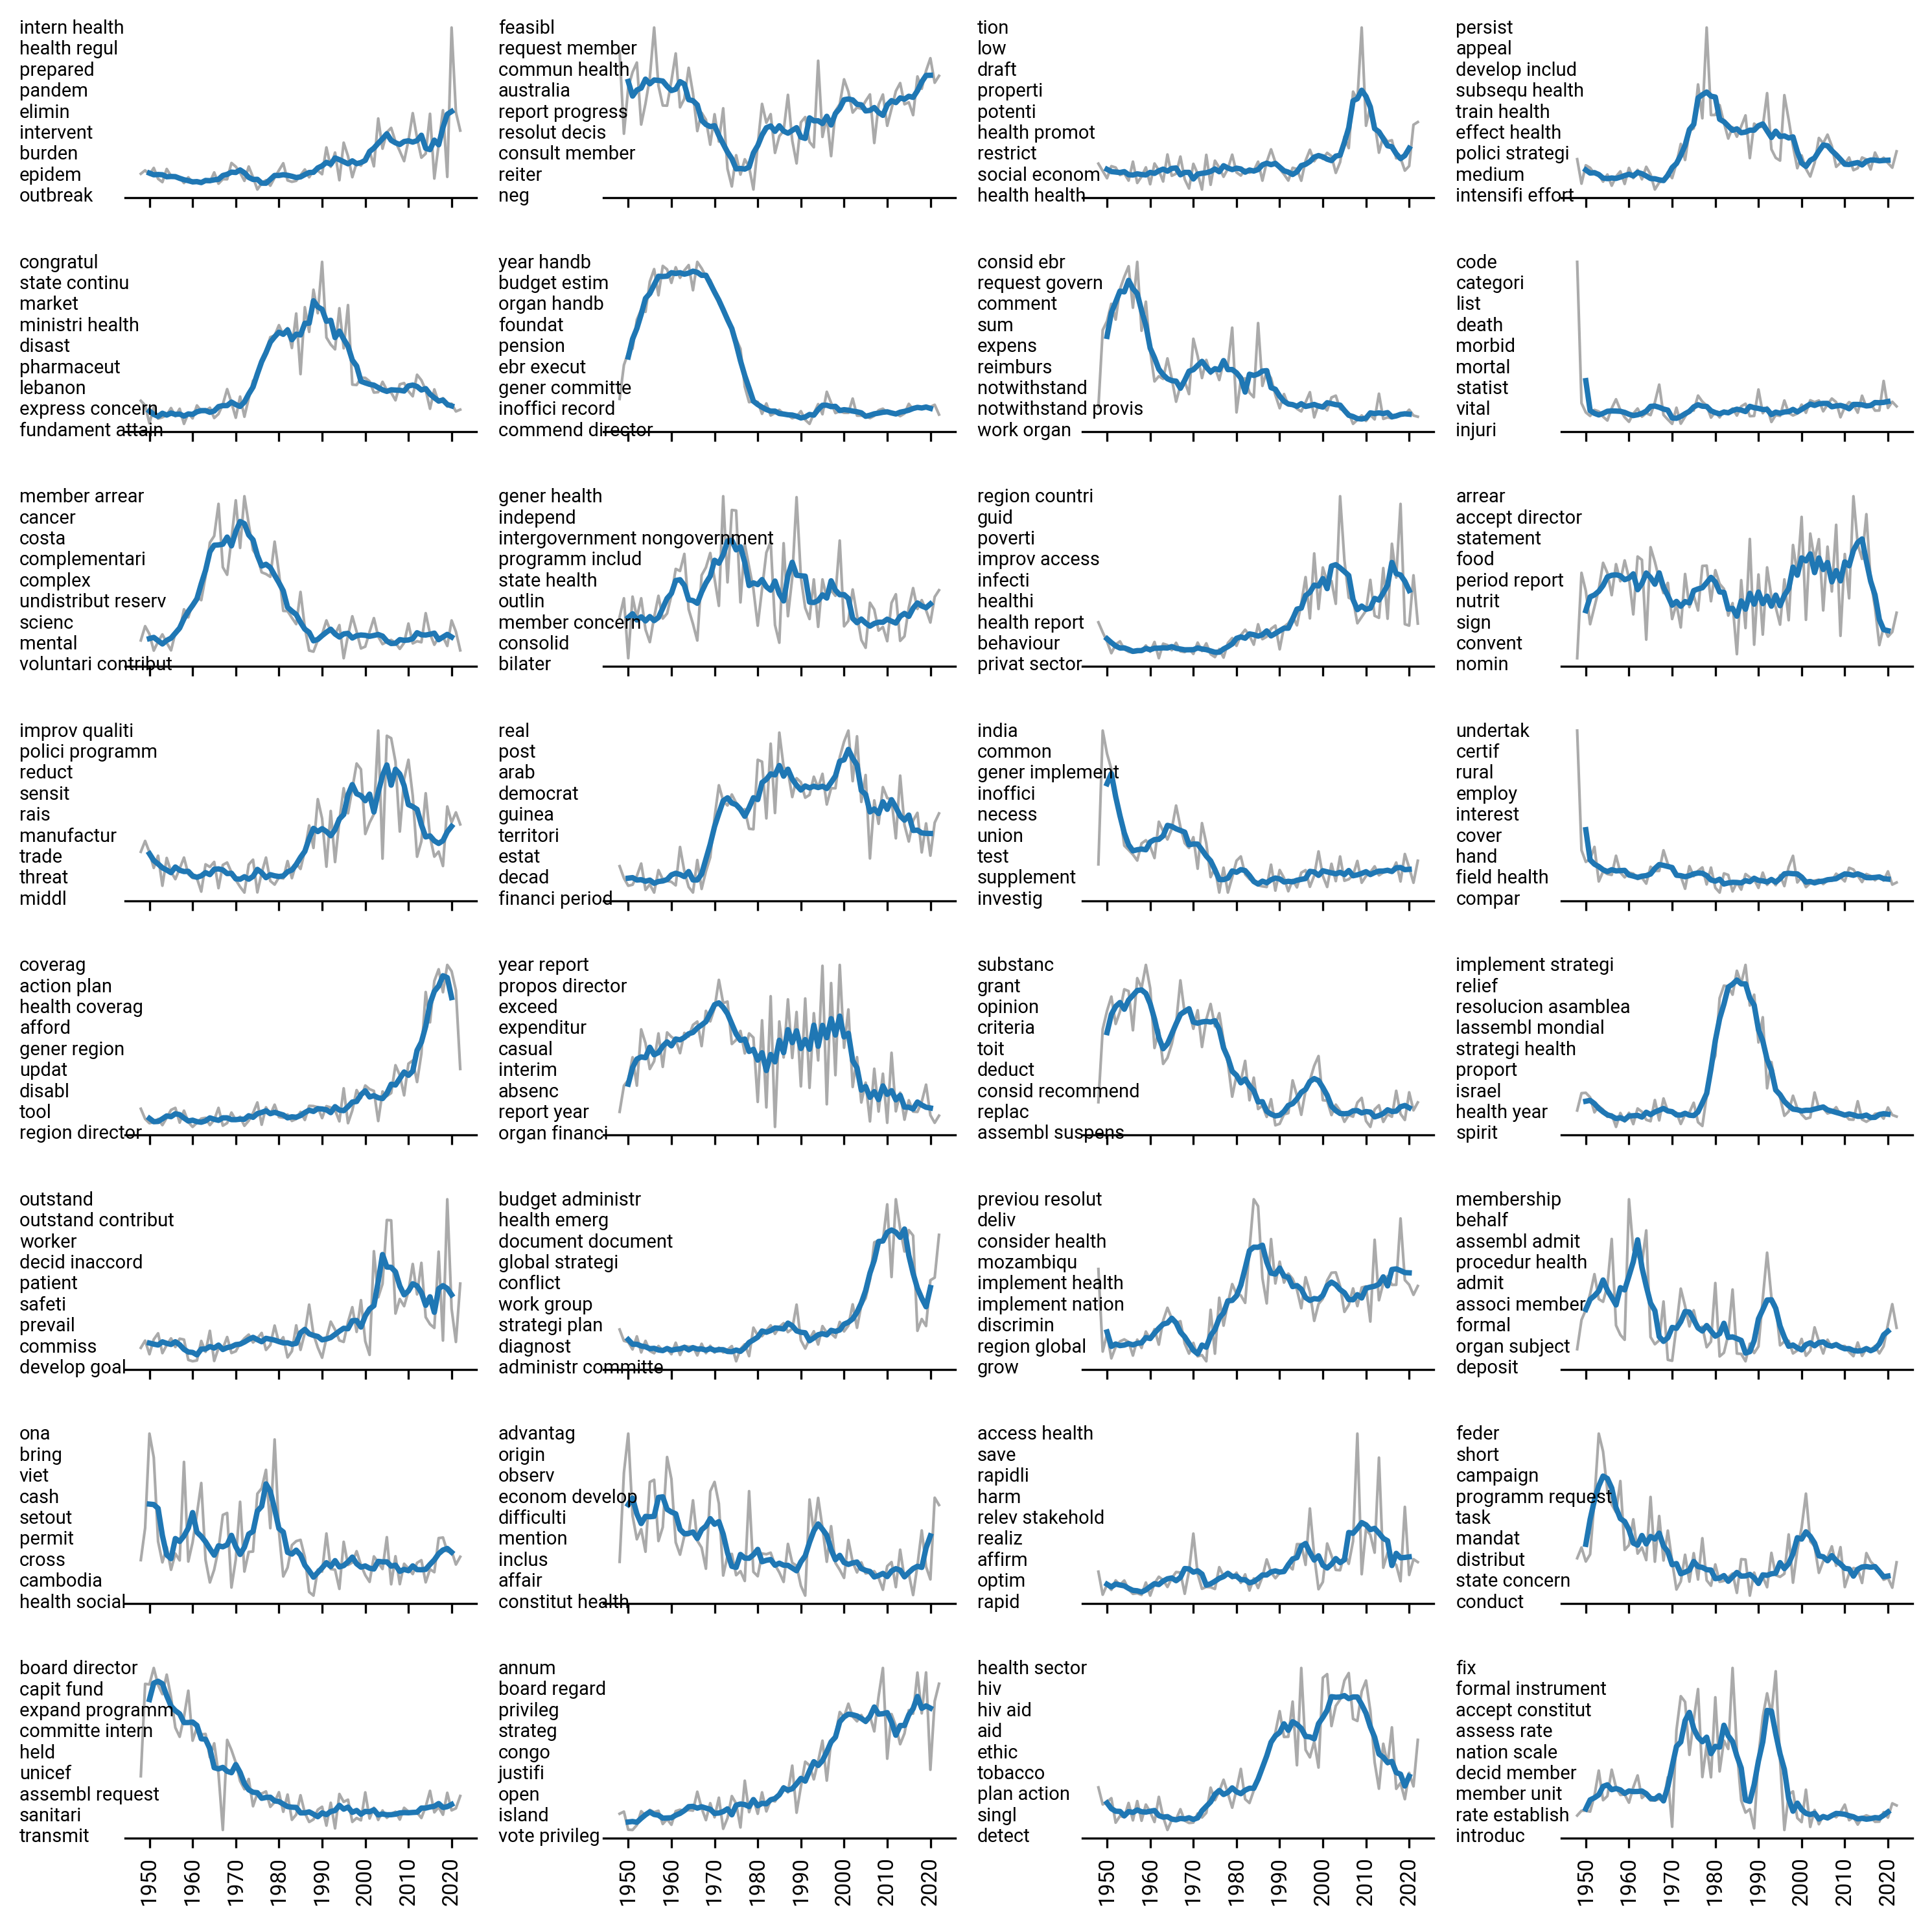

In [26]:
df_keywords_normalized['cluster'] = kmeans.labels_
df_topic_clusters = df_keywords_normalized.groupby('cluster').mean()
cluster_map = df_keywords_normalized.groupby('cluster').indices

n_rows = 8
n_cols = 4
window_size = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10), sharex='all')
k=0
for i in range(n_rows):
    for j in range(n_cols):
        if k>=n_clusters:
            continue
        Y1 = df_topic_clusters.loc[k, :] #/df.groupby('year')['number'].count()
        ax[i,j].plot(Y1, color='#aaaaaa', linewidth=1)
        ax[i,j].plot(Y1.rolling(window_size, center=True).mean(), linewidth=2)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        ax[i,j].set_yticks([])
        # ax[0].spines['bottom'].set_visible(False)
        X = df_keywords_normalized.reset_index().loc[cluster_map[k], 'index'].to_list()
        some_topics = "\n".join(random.sample(X, min([len(X), 9])))
        ax[i,j].text(-0.3, 1, some_topics, transform=ax[i,j].transAxes, fontsize=7, ha="left", va="top")
        ax[i,j].set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
        if i==n_rows-1:
            ax[i,j].set_xticklabels([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], rotation=90, fontsize=8)
        k=k+1
fig.tight_layout()
# ax[i,j].text(0.1, 0.9, "Topics grouped into cluster by similar in their time evolution", transform=fig.transFigure, fontsize=12, ha="left")

## Relationships among WHA resolutions

Next, to find relationships among WHA resolutions, I startd from the same TF-IDF based topics for each resolution. Then for each pair of resolutions, I added an "edge" if they share a sufficient number of topics. This way, I generated a network in which nodes are made up of WHA resolutions and edges depict resolution pairs sharing common topics. 

The set of parameters used to generate the topics and form the edges of the network are crucial towards the characteristics of the network. For example, the parameters we discussed before - minimum document frequency, maximum document frequency, n-grams used, number of topics per resolution - all matter. Fixing the minimum document frequency to 50 documents, maximum document frequency to 10%, using monograms and bigrams, below I varied (a) the number of topics per resolution and (b) minimum number of shared topics to form an edge, to generate a network of WHA resolutions.

For each set of parameters, I used the Louvain method for community detection on the resulting network, and calculated a set of metrics to assess the quality of detected communities (partitions). For example, `modularity` which is the value optimized in the Louvain's method, measures the density of links inside communities compared to links between communities, is one such metric. A high modularity reflects a good partitioning. However, a lot of nodes (resolutions) with no edges with any other nodes, i.e. resolutions that are in their own partition and aren't associated with any other resolutions, will result in a high modularity. 

To correct for this, I also calculated other metrics - number of partitions, number of non-isolated partitions (partitions with more than one resolution in them), fraction of resolutions in non-isolated partitions, and average number of resolutions per non-isolated partition. Among these, fraction of resolutions in non-isolated partitions is a metric that one would like to be high - a lot of resolutions are grouped with one other resolution into some partition this way. As one would expect, more topics per resolution increases this metric, and more common topics to form an edge decreases this metric. 

Modularity and the fraction of resolutions in non-isolated partitions follow opposite trends. To balance these two forces, both of which we want to be high, I defined a `goodness score` of partitioning as their product of these two metrics. I found that this goodness of partition is the highest (0.76) when the number of topics per resolution is 5 and the minimum number of common topics for an edge is 2. So I used those parameters to generate the WHA network.

In [ ]:
# Scanning n_w and min. no. of n_w for an edge against modularity value and no. of partitions

min_df = 50/len(stemmized_corpus)
max_df = 0.05

n_w_list = [5, 10, 15, 20]
# n_w_list = [2, 5]
min_n_w_list = [1, 2, 3, 4, 5]

num_partitions = np.zeros((len(n_w_list), len(min_n_w_list)), dtype=int)
num_ni_partitions = np.zeros((len(n_w_list), len(min_n_w_list)), dtype=int)
res_in_ni_partitions = np.zeros((len(n_w_list), len(min_n_w_list)))
res_per_ni_partition = np.zeros((len(n_w_list), len(min_n_w_list)), dtype=int)
modularity_score = np.zeros((len(n_w_list), len(min_n_w_list)))
goodness_score = np.zeros((len(n_w_list), len(min_n_w_list)))
f_single_partitions = np.zeros((len(n_w_list), len(min_n_w_list)))
for I, n_w_this in enumerate(n_w_list):
    for J, min_n_w_this in enumerate(min_n_w_list):
        print(f"n_w = {n_w_this}, min_n_w = {min_n_w_this}")
        if min_n_w_this>n_w_this:
            continue
        keywords_text = extract_keywords(stemmized_corpus, n_w_this, min_df, max_df, ngram_range=(1,1))
        all_keywords_text = list(set([d for dd in keywords_text for d in dd]))

        wha_text_network = np.zeros((len(keywords_text), len(keywords_text)))
        for i in range(len(keywords_text)):
            for j in range(len(keywords_text)):
                if i==j:
                    continue
                wha_text_network[i,j] = 1 if len(set(keywords_text[i]).intersection(keywords_text[j]))>=min_n_w_this else 0
                # wha_text_network[i,j] = len(set(keywords_text[i]).intersection(keywords_text[j])) if len(set(keywords_text[i]).intersection(keywords_text[j]))>=min_n_w_this else 0

        G = nx.from_numpy_array(wha_text_network)
        
        partition = community_louvain.best_partition(G)
        num_partitions[I,J] = len(set(list(partition.values())))
        modularity_score[I,J] = community_louvain.modularity(partition, G)

        partition_n_docs = [ 0 for _ in range(num_partitions[I,J]) ]
        for i, document_keywords in enumerate(keywords_text):
            doc_part = partition[i]
            partition_n_docs[doc_part]+=1

        f_single_partitions[I,J] = sum(np.array(partition_n_docs)==1)/num_partitions[I,J]
        num_ni_partitions[I,J] = num_partitions[I,J]*(1-f_single_partitions[I,J])
        res_in_ni_partitions[I,J] = 1-f_single_partitions[I,J]*num_partitions[I,J]/len(stemmized_corpus)
        res_per_ni_partition[I,J] = (len(stemmized_corpus)-f_single_partitions[I,J]*num_partitions[I,J])/(num_partitions[I,J]*(1-f_single_partitions[I,J]))
        goodness_score[I,J] = modularity_score[I,J]*(1-f_single_partitions[I,J]*num_partitions[I,J]/len(stemmized_corpus))

Text(0.5, 210.1666666666666, 'Minimum topics for edge')

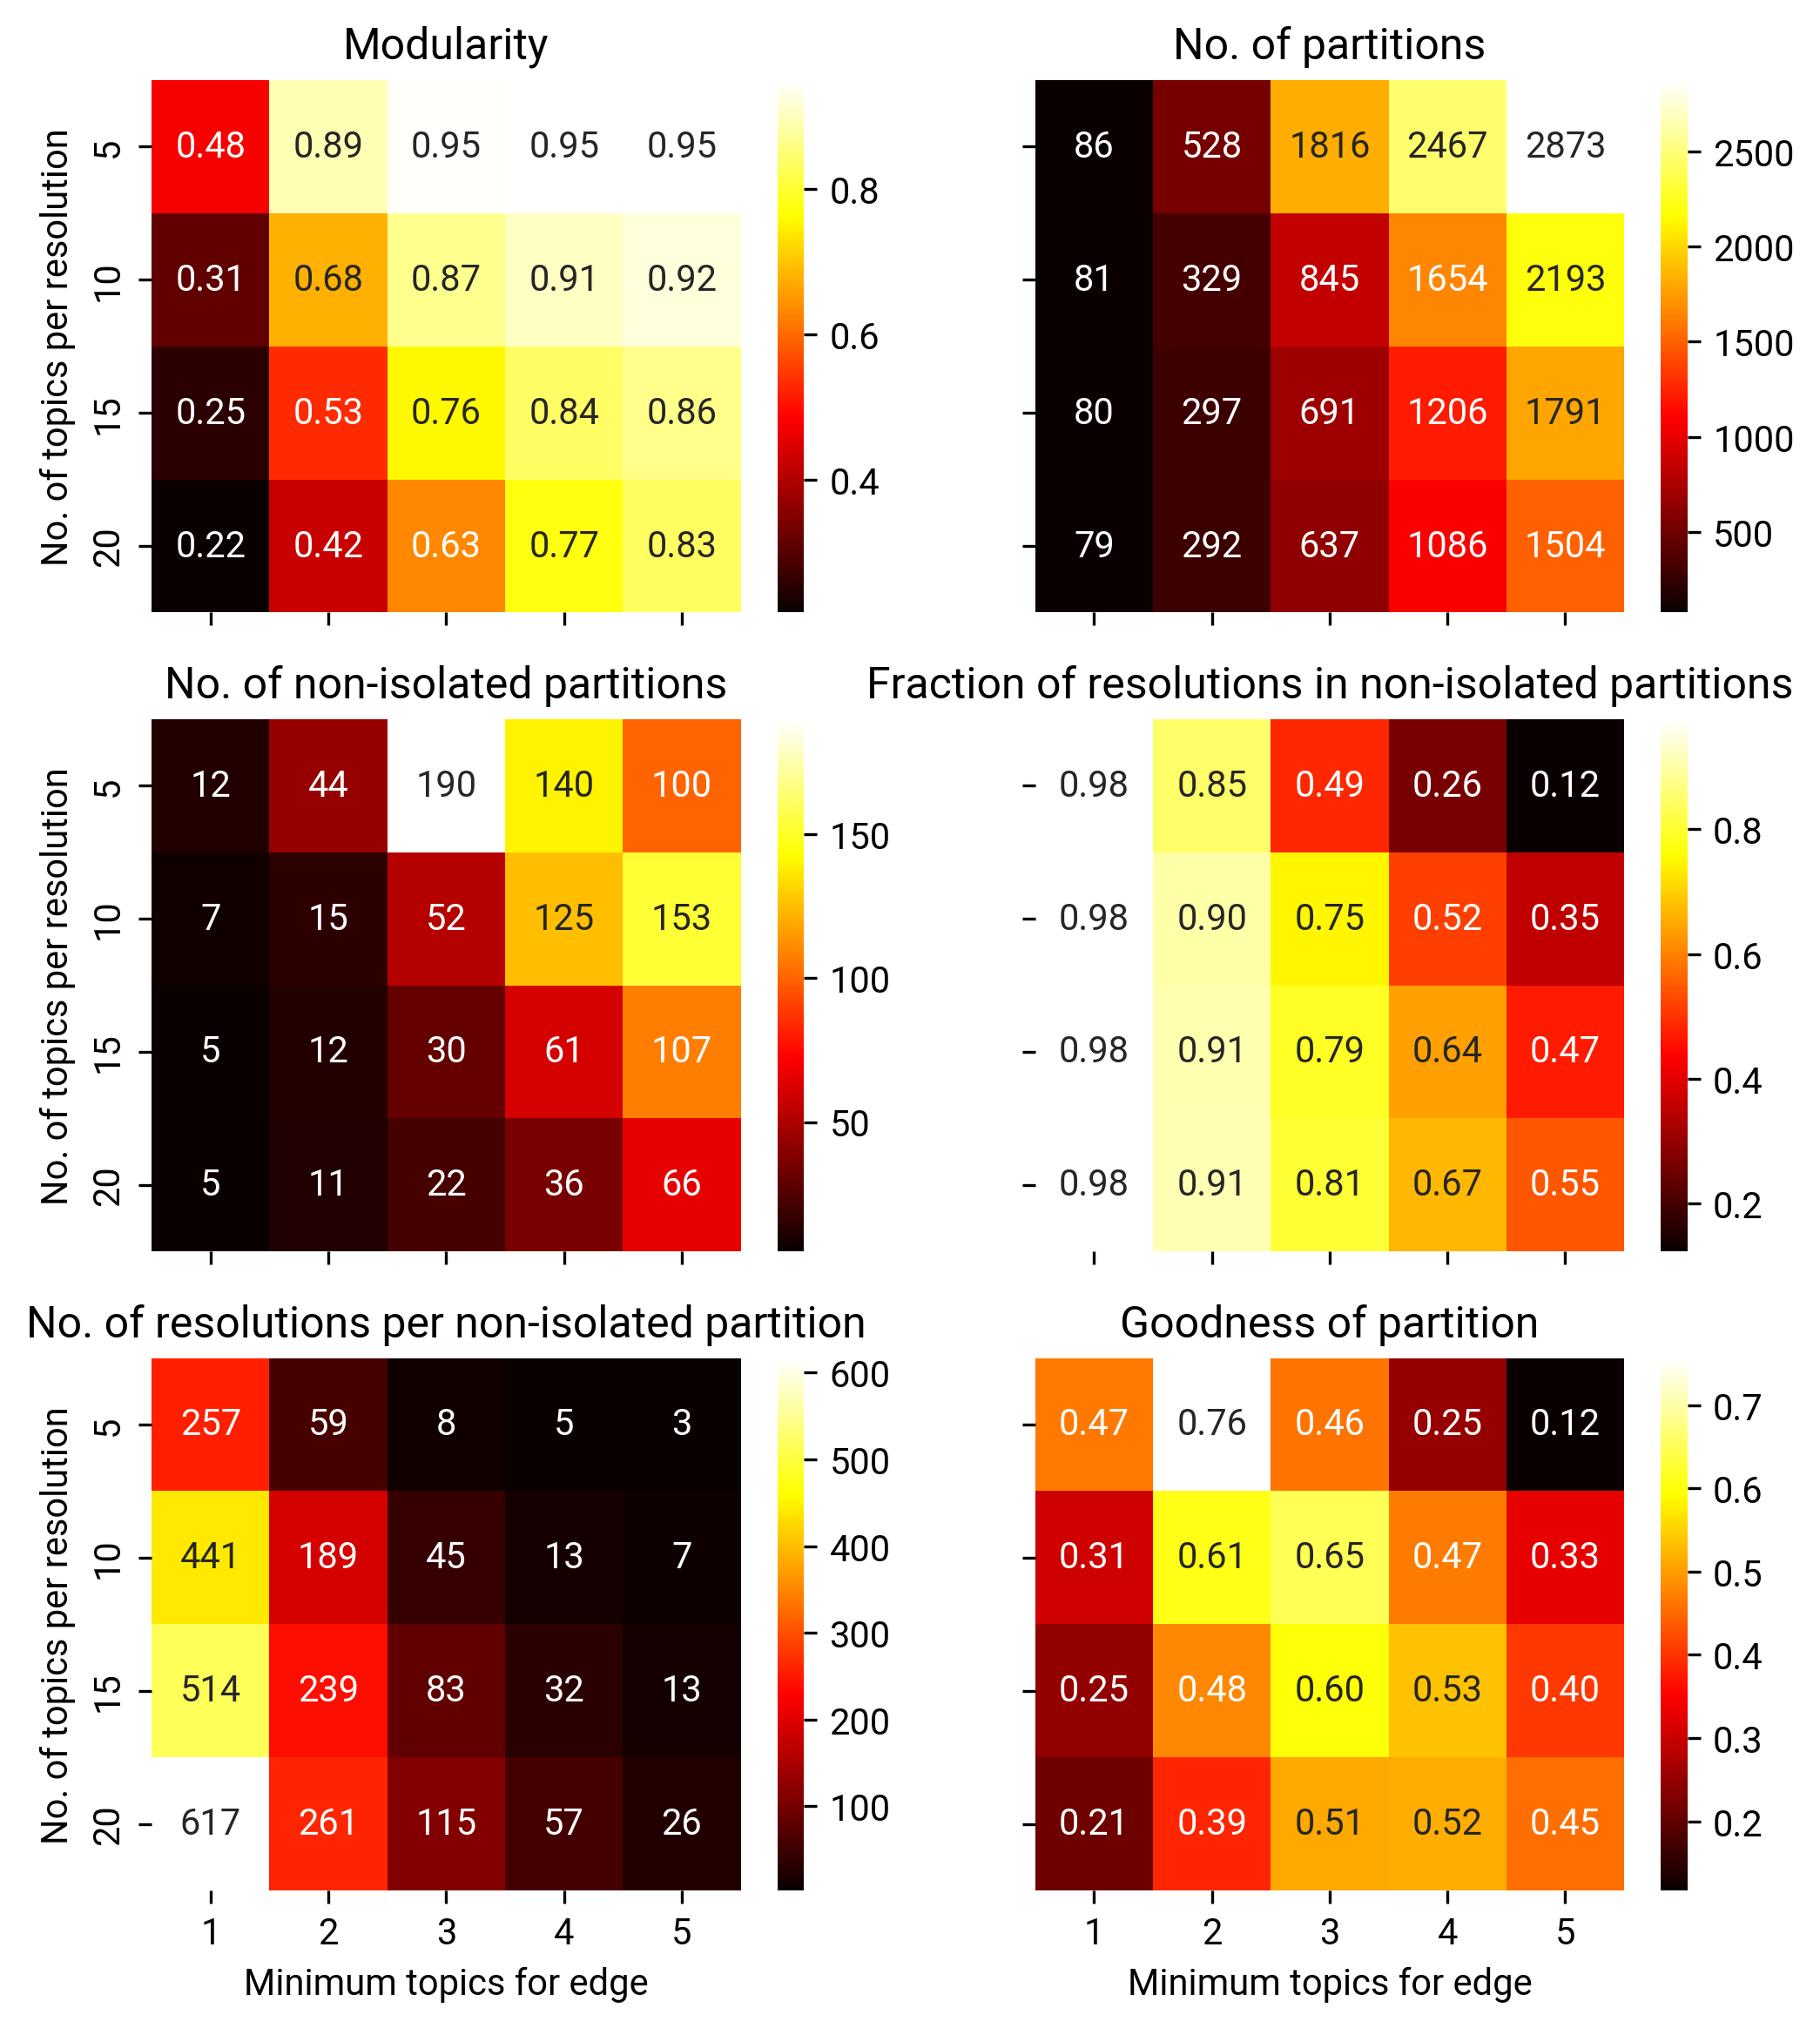

In [236]:

fig, ax = plt.subplots(3, 2, figsize=(8,9), sharex='all', sharey='all')
sns.heatmap(pd.DataFrame(modularity_score, columns=min_n_w_list, index=n_w_list), ax=ax[0,0], cmap='hot', annot=True, fmt='.2f')
sns.heatmap(pd.DataFrame(num_partitions, columns=min_n_w_list, index=n_w_list), ax=ax[0,1], cmap='hot', fmt='d', annot=True)
sns.heatmap(pd.DataFrame(num_ni_partitions, columns=min_n_w_list, index=n_w_list), ax=ax[1,0], cmap='hot', fmt='d', annot=True)
sns.heatmap(pd.DataFrame(res_in_ni_partitions, columns=min_n_w_list, index=n_w_list), ax=ax[1,1], cmap='hot', fmt='.2f', annot=True)
sns.heatmap(pd.DataFrame(res_per_ni_partition, columns=min_n_w_list, index=n_w_list), ax=ax[2,0], cmap='hot', fmt='d', annot=True)
sns.heatmap(pd.DataFrame(goodness_score, columns=min_n_w_list, index=n_w_list), ax=ax[2,1], cmap='hot', fmt='.2f', annot=True)
# sns.heatmap(pd.DataFrame(np.sqrt(num_ni_partitions)*goodness_score, columns=min_n_w_list, index=n_w_list), ax=ax[2,1], cmap='hot', fmt='.2f', annot=True)

ax[0,0].set_title('Modularity')
ax[0,1].set_title('No. of partitions')
ax[1,0].set_title('No. of non-isolated partitions')
ax[1,1].set_title('Fraction of resolutions in non-isolated partitions')
ax[2,0].set_title('No. of resolutions per non-isolated partition')
ax[2,1].set_title('Goodness of partition')
ax[0,0].set_ylabel('No. of topics per resolution')
ax[1,0].set_ylabel('No. of topics per resolution')
ax[2,0].set_ylabel('No. of topics per resolution')
ax[2,0].set_xlabel('Minimum topics for edge')
ax[2,1].set_xlabel('Minimum topics for edge')

In [ ]:
n_w = 5
min_df = 50/len(stemmized_corpus)
max_df = 0.05

keywords_text = extract_keywords(stemmized_corpus, n_w, min_df, max_df, ngram_range=(1,2))
all_keywords_text = list(set([d for dd in keywords_text for d in dd]))
print(len(all_keywords_text))

for i, document_keywords in enumerate(keywords_text):
    print(f"Document {i+1}: {df.loc[i, 'title']} - {document_keywords}")

wha_text_network = np.zeros((len(keywords_text), len(keywords_text)))
for i in range(len(keywords_text)):
    for j in range(len(keywords_text)):
        if i==j:
            continue
        wha_text_network[i,j] = 1 if len(set(keywords_text[i]).intersection(keywords_text[j]))>=2 else 0

In [ ]:
partition = community_louvain.best_partition(G, resolution=2.0, randomize=False)
n_partitions = len(set(list(partition.values())))
print(f"We have {n_partitions} partitions")
print(f"Modularity score: {community_louvain.modularity(partition, G)}")

counter = Counter(list(partition.values()))
new_order_partition = sorted(counter, key=counter.get, reverse=True)

partition_topics = [ [] for _ in range(n_partitions) ]
partition_n_docs = [ 0 for _ in range(n_partitions) ]
for i, document_keywords in enumerate(keywords_text):
    doc_part = new_order_partition.index(partition[i])
    partition_topics[doc_part].extend(document_keywords)
    partition_n_docs[doc_part]+=1
    
# sort_index = np.argsort(-np.array(partition_n_docs))
# partition_n_docs = [partition_n_docs[s] for s in sort_index]
# partition_topics = [partition_topics[s] for s in sort_index]

for i in range(len(partition_topics)):
    counter = Counter(partition_topics[i])
    partition_topics[i] = sorted(counter, key=counter.get, reverse=True)
    partition_topics[i] = ", ".join(partition_topics[i][:min([10, len(partition_topics[i])])])
    if partition_n_docs[i]==1:
        continue
    print(f"{i}: {round(100*partition_n_docs[i]/len(stemmized_corpus),2)}% documents - {partition_topics[i]}")

df_topics_year = pd.DataFrame(0, index=range(n_partitions), columns=all_years)
louvain_parition = {}
resolution_topics = {}
louvain_topics = {}
for i in range(len(stemmized_corpus)):
    louvain_parition[i] = new_order_partition.index(partition[i])
    resolution_topics[i] = ", ".join(keywords_text[i])
    louvain_topics[i] = partition_topics[louvain_parition[i]]
    df_topics_year.loc[louvain_parition[i], df.loc[i, 'year']]+=1

In [318]:
G = nx.from_numpy_array(wha_text_network)
nx.set_node_attributes(G, df.loc[:, "year"].to_dict(), "year")
nx.set_node_attributes(G, louvain_parition, "louvain_partition")
nx.set_node_attributes(G, resolution_topics, "resolution_topics")
nx.set_node_attributes(G, louvain_topics, "partition_topics")

output_file = 'wha_text_network.graphml'

nx.write_graphml(G, output_file)

### Network of WHA resolutions

![WHA resolution network with nodes colored by the partition they belong to, and topics of the partitions.](WHA_network_annotated.png)

In [ ]:
# nx.write_graphml(G_year, 'wha_1948.graphml')
clustering_coeff_year = []
five_years = [1947]+list(range(1952, 2023, 5))
for i in range(1, len(five_years)):
    year_start = five_years[i-1]
    year_end = five_years[i]
    subgraph_nodes = [n for n, d in G.nodes(data=True) if d['year']>year_start and d['year']<=year_end]
    G_year = G.subgraph(subgraph_nodes)
    clustering_coeff_year.append(nx.average_clustering(G_year))
    
fig, ax = plt.subplots()
ax.plot(five_years[1:], clustering_coeff_year)

### Time evolution of topics found via WHA resolution network

From the Louvain partitions of the WHA resolution network, I found the most frequent topics in the resolutions belonging to each partition and assigned them as the "partition topics". 

#### **Partition topics and their time evolution**  
For each topic, on the y-axis, I plotted the fraction of documents per year that mention the topic.

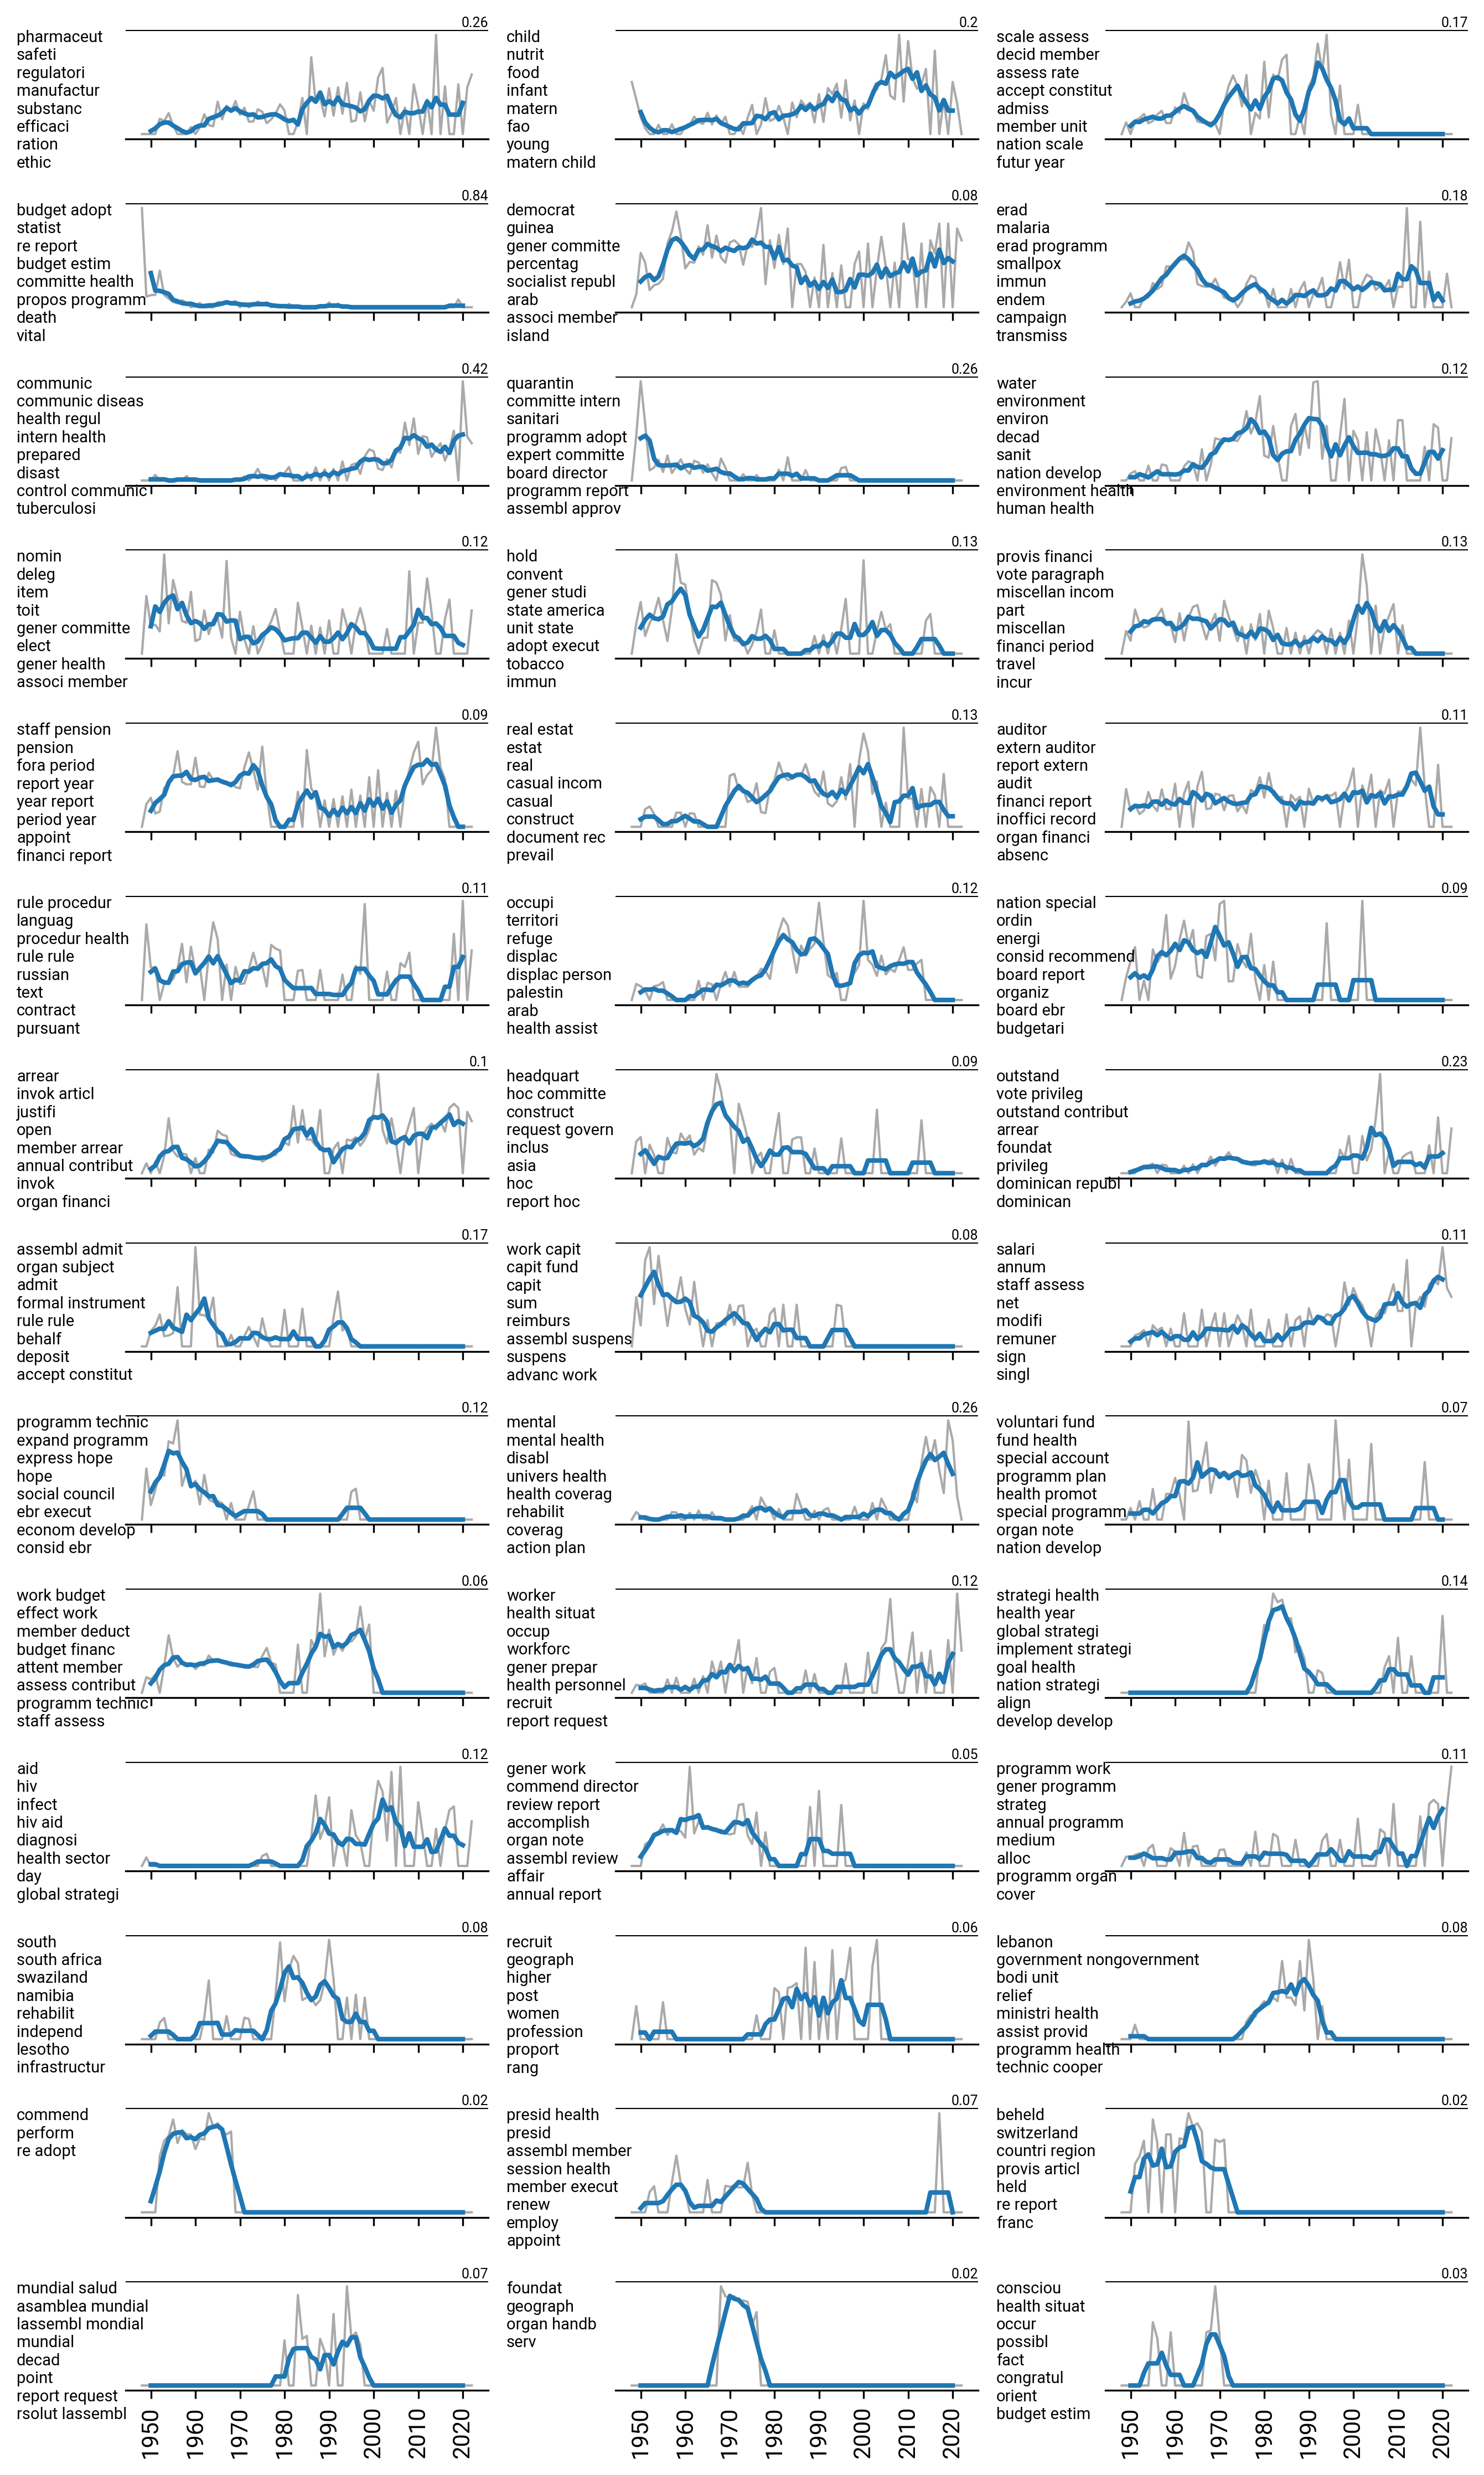

In [433]:
partition_size_threshold = 5
n_big_partitions = sum([x>partition_size_threshold for x in partition_n_docs])
window_size = 5
n_rows = 14
n_cols = 3
fig, ax = plt.subplots(n_rows, n_cols, figsize=(9,15), sharex='all')
i=0
j=0
k=0
for p in range(len(partition_n_docs)):
    if partition_n_docs[p]<=partition_size_threshold:
        continue
    Y1 = df_topics_year.loc[p, :]/df.groupby('year')['number'].count()
    ax[i,j].plot(all_years, Y1, color='#aaaaaa', linewidth=1)
    ax[i,j].plot(all_years, Y1.rolling(window_size, center=True).mean(), linewidth=2)
    ax[i,j].spines['top'].set_visible(False)
    ax[i,j].spines['right'].set_visible(False)
    ax[i,j].spines['left'].set_visible(False)
    # ax[i,j].spines['bottom'].set_visible(False)
    ax[i,j].set_yticks([])
    ax[i,j].axhline(ax[i,j].get_ylim()[1], color="#000000", linewidth=1)
    ax[i,j].text(ax[i,j].get_xlim()[1], ax[i,j].get_ylim()[1], round(ax[i,j].get_ylim()[1],2), fontsize=6, ha="right", va="bottom")
    # ax[i,j].set_xticks([])
    topic_names = "\n".join(partition_topics[k].split(", ")[:8])
    ax[i,j].text(-0.3, 1, topic_names, transform=ax[i,j].transAxes, fontsize=7, ha="left", va="top")
    if i==n_rows-1:
        ax[i,j].set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
        ax[i,j].set_xticklabels([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], rotation=90)
    k+=1
    j=j+1
    if j==n_cols:
        j=0
        i=i+1
    
fig.tight_layout()


## Scale of assessments

I also extracted the scale of assessments every ten years, specifically for the years 1962, 1972, 1982, 1992, 2002, 2012 and 2022. These denote the percentage contributions to the WHO budget by each country. I visualized these on a heatmap and clustered countries that have contributed similarly over the years into groups.

There seem to 4-6 groups of countries according to their level of contributions + changes in their contributions. The USA, China, Canada, Italy, Japan, Germany, France and the UK have contributed most fractions of the budget. 

#### **Relative contributions of different countries to WHO budget over the years, countries grouped by similarity**  
Lighter colors indicate higher contribution

![Scale of assessments](scale_of_assessments_clustermap.png)

## Future directions

1. Quantify WHA resolution network characteristics over years in n-year periods: understand evolution of network architecture.
2. Compare and supplement usage of resolution titles to such above analysis.
3. Analyze citation network of WHA resolutions.